In [15]:
from catboost import Pool, CatBoostRegressor, cv

In [16]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import shap

In [17]:
from sklearn.preprocessing import QuantileTransformer

In [32]:
# 0.41
cols = [
    'ch',
    'Beta_watch-relax',
    #'Alpha_watch-relax',
    'Theta_watch-relax',
    #'Beta/Alpha',
    'Beta/(Alpha + Theta)',
    'Theta_ratio',
    'Beta_ratio',
    #'Alpha_ratio',
    'Theta',
    #'Alpha',
    'Beta',
    #'TotalAbsPow'
]

In [33]:
data_all = pd.read_csv('matrix_cleaned_bio.csv')
data_all

,Theta,Alpha,Beta,Theta_ratio,Alpha_ratio,Beta_ratio,TotalAbsPow,Theta_watch-relax,Alpha_watch-relax,Beta_watch-relax,...,Subj,film,ch,labels,ECG_Rate_Mean_watch,SCR_Peaks_N_watch,SCR_Peaks_Amplitude_Mean_watch,SCR_Peaks_Amplitude_Mean_relax,SCR_Peaks_Amplitude_Mean_watch-relax,EMG_Activation_N_watch
0,13.011456,5.120684,6.871645,0.518855,0.206702,0.274443,25.179888,3.734071,2.042683,2.376408,...,1,1,1,10,64.891654,20,0.000148,0.000012,0.000136,205
1,6.563671,3.319401,5.831020,0.416457,0.212868,0.370676,15.653934,0.458212,1.255145,1.792163,...,1,1,2,10,64.891654,20,0.000148,0.000012,0.000136,205
2,4.540355,2.501262,6.033912,0.340833,0.193027,0.466140,12.963027,-1.882338,0.240152,2.327508,...,1,1,3,10,64.891654,20,0.000148,0.000012,0.000136,205
3,9.124489,5.293534,7.495714,0.411476,0.247264,0.341260,21.925581,3.279015,1.941784,2.923710,...,1,1,4,10,64.891654,20,0.000148,0.000012,0.000136,205
4,12.488048,7.751883,7.367271,0.455952,0.278923,0.265125,27.984870,4.237352,3.184184,1.384729,...,1,1,6,10,64.891654,20,0.000148,0.000012,0.000136,205
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2745,21.193541,4.736696,11.184029,0.568394,0.131438,0.300168,37.174902,12.163021,-3.264240,-1.078549,...,21,8,14,1,14.981789,20,0.000001,0.000004,-0.000003,0
2746,17.104650,3.568935,8.170350,0.593663,0.123477,0.282860,28.988928,10.446148,-2.107908,-1.032185,...,21,8,15,1,14.981789,20,0.000001,0.000004,-0.000003,0
2747,7.015250,1.543985,5.893248,0.484762,0.106493,0.408745,14.441618,3.185019,-1.219592,-0.234495,...,21,8,16,1,14.981789,20,0.000001,0.000004,-0.000003,0
2748,12.301713,3.111477,13.173423,0.430884,0.108658,0.460458,28.584464,7.211230,-0.653889,3.956880,...,21,8,17,1,14.981789,20,0.000001,0.000004,-0.000003,0


In [34]:
X_test = data_all.loc[(data_all['film']  == 2)].reset_index(drop=True)
X_train = data_all.loc[(data_all['film'] != 2)].reset_index(drop=True)

y_train = X_train['labels']
y_test_inv = np.array(X_test['labels'])
train_film = X_train['film']
train_subj = X_train['Subj']
train_ch = X_train['ch']
test_film = X_test['film']
test_subj = X_test['Subj']
test_ch = np.array(X_test['ch'])

X_train = X_train[cols]
X_test = X_test[cols]


qt_train = QuantileTransformer(output_distribution='normal',
                           copy=True)
y_train = pd.DataFrame(qt_train.fit_transform(np.array(y_train).reshape(-1, 1)))
qt_test = QuantileTransformer(output_distribution='normal',
                             copy=True)
y_test = pd.DataFrame(qt_test.fit_transform(np.array(y_test_inv).reshape(-1, 1)))

n_quantiles (1000) is greater than the total number of samples (344). n_quantiles is set to n_samples.


In [35]:
import shap

In [36]:
X_test.columns

Index(['ch', 'Beta_watch-relax', 'Theta_watch-relax', 'Beta/(Alpha + Theta)',
       'Theta_ratio', 'Beta_ratio', 'Theta', 'Beta'],
      dtype='object')

In [37]:
cols = [
    'ECG_Rate_Mean_watch', 'SCR_Peaks_N_watch',
    'SCR_Peaks_Amplitude_Mean_watch', 'SCR_Peaks_Amplitude_Mean_relax',
    'SCR_Peaks_Amplitude_Mean_watch-relax', 'EMG_Activation_N_watch'
    'ShanEn',
    'Beta_watch-relax',
    'Alpha_watch-relax',
    #'Theta_watch-relax',
    'Beta/Alpha',
    #'Beta/(Alpha + Theta)',
    'Theta_ratio',
    #'Beta_ratio',
    #'Alpha_ratio',
    #'Theta',
    #'Alpha',
    #'Beta',
    #'TotalAbsPow'
]

In [38]:
model = CatBoostRegressor(cat_features=['ch'])
model.fit(X_train, y_train)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, max_display=len(X_train.columns), show=False)

Learning rate set to 0.047035
0:	learn: 1.7771931	total: 18.1ms	remaining: 18.1s
1:	learn: 1.7694717	total: 32.2ms	remaining: 16s
2:	learn: 1.7632155	total: 49.7ms	remaining: 16.5s
3:	learn: 1.7569465	total: 66.7ms	remaining: 16.6s
4:	learn: 1.7511481	total: 81.5ms	remaining: 16.2s
5:	learn: 1.7443334	total: 96.7ms	remaining: 16s
6:	learn: 1.7385164	total: 110ms	remaining: 15.6s
7:	learn: 1.7334684	total: 132ms	remaining: 16.4s
8:	learn: 1.7285338	total: 148ms	remaining: 16.3s
9:	learn: 1.7225471	total: 165ms	remaining: 16.4s
10:	learn: 1.7186215	total: 184ms	remaining: 16.6s
11:	learn: 1.7133873	total: 205ms	remaining: 16.9s
12:	learn: 1.7095820	total: 224ms	remaining: 17s
13:	learn: 1.7065680	total: 240ms	remaining: 16.9s
14:	learn: 1.7023644	total: 261ms	remaining: 17.1s
15:	learn: 1.6995816	total: 280ms	remaining: 17.2s
16:	learn: 1.6964103	total: 296ms	remaining: 17.1s
17:	learn: 1.6927629	total: 315ms	remaining: 17.2s
18:	learn: 1.6893925	total: 332ms	remaining: 17.2s
19:	learn: 

168:	learn: 1.4935266	total: 3.34s	remaining: 16.4s
169:	learn: 1.4929955	total: 3.36s	remaining: 16.4s
170:	learn: 1.4927856	total: 3.37s	remaining: 16.3s
171:	learn: 1.4920413	total: 3.38s	remaining: 16.3s
172:	learn: 1.4909868	total: 3.4s	remaining: 16.3s
173:	learn: 1.4904288	total: 3.42s	remaining: 16.2s
174:	learn: 1.4892784	total: 3.44s	remaining: 16.2s
175:	learn: 1.4879878	total: 3.46s	remaining: 16.2s
176:	learn: 1.4876140	total: 3.48s	remaining: 16.2s
177:	learn: 1.4869290	total: 3.5s	remaining: 16.2s
178:	learn: 1.4857125	total: 3.52s	remaining: 16.1s
179:	learn: 1.4843519	total: 3.54s	remaining: 16.1s
180:	learn: 1.4834661	total: 3.56s	remaining: 16.1s
181:	learn: 1.4827868	total: 3.58s	remaining: 16.1s
182:	learn: 1.4812355	total: 3.6s	remaining: 16.1s
183:	learn: 1.4803832	total: 3.63s	remaining: 16.1s
184:	learn: 1.4793484	total: 3.65s	remaining: 16.1s
185:	learn: 1.4774041	total: 3.67s	remaining: 16.1s
186:	learn: 1.4765485	total: 3.7s	remaining: 16.1s
187:	learn: 1.47

334:	learn: 1.3307707	total: 6.66s	remaining: 13.2s
335:	learn: 1.3306736	total: 6.68s	remaining: 13.2s
336:	learn: 1.3299667	total: 6.69s	remaining: 13.2s
337:	learn: 1.3291701	total: 6.71s	remaining: 13.1s
338:	learn: 1.3281752	total: 6.73s	remaining: 13.1s
339:	learn: 1.3272124	total: 6.75s	remaining: 13.1s
340:	learn: 1.3267369	total: 6.77s	remaining: 13.1s
341:	learn: 1.3262064	total: 6.79s	remaining: 13.1s
342:	learn: 1.3258160	total: 6.81s	remaining: 13s
343:	learn: 1.3251591	total: 6.82s	remaining: 13s
344:	learn: 1.3243958	total: 6.84s	remaining: 13s
345:	learn: 1.3237098	total: 6.86s	remaining: 13s
346:	learn: 1.3231738	total: 6.88s	remaining: 13s
347:	learn: 1.3224926	total: 6.9s	remaining: 12.9s
348:	learn: 1.3223250	total: 6.92s	remaining: 12.9s
349:	learn: 1.3210207	total: 6.94s	remaining: 12.9s
350:	learn: 1.3197339	total: 6.96s	remaining: 12.9s
351:	learn: 1.3187856	total: 6.97s	remaining: 12.8s
352:	learn: 1.3183057	total: 6.99s	remaining: 12.8s
353:	learn: 1.3169121	t

502:	learn: 1.2098137	total: 9.78s	remaining: 9.67s
503:	learn: 1.2092878	total: 9.8s	remaining: 9.65s
504:	learn: 1.2085188	total: 9.83s	remaining: 9.64s
505:	learn: 1.2079770	total: 9.85s	remaining: 9.61s
506:	learn: 1.2077408	total: 9.86s	remaining: 9.59s
507:	learn: 1.2075903	total: 9.88s	remaining: 9.57s
508:	learn: 1.2070063	total: 9.9s	remaining: 9.55s
509:	learn: 1.2064635	total: 9.92s	remaining: 9.53s
510:	learn: 1.2060774	total: 9.93s	remaining: 9.51s
511:	learn: 1.2053253	total: 9.95s	remaining: 9.49s
512:	learn: 1.2040723	total: 9.97s	remaining: 9.46s
513:	learn: 1.2038055	total: 9.99s	remaining: 9.44s
514:	learn: 1.2032930	total: 10s	remaining: 9.42s
515:	learn: 1.2031457	total: 10s	remaining: 9.4s
516:	learn: 1.2026095	total: 10s	remaining: 9.38s
517:	learn: 1.2020833	total: 10.1s	remaining: 9.36s
518:	learn: 1.2019176	total: 10.1s	remaining: 9.34s
519:	learn: 1.2013926	total: 10.1s	remaining: 9.32s
520:	learn: 1.2008502	total: 10.1s	remaining: 9.29s
521:	learn: 1.2003340

661:	learn: 1.1155915	total: 12.7s	remaining: 6.51s
662:	learn: 1.1146172	total: 12.8s	remaining: 6.49s
663:	learn: 1.1143872	total: 12.8s	remaining: 6.47s
664:	learn: 1.1137047	total: 12.8s	remaining: 6.45s
665:	learn: 1.1120676	total: 12.8s	remaining: 6.43s
666:	learn: 1.1116342	total: 12.8s	remaining: 6.41s
667:	learn: 1.1110265	total: 12.9s	remaining: 6.39s
668:	learn: 1.1107931	total: 12.9s	remaining: 6.37s
669:	learn: 1.1105368	total: 12.9s	remaining: 6.35s
670:	learn: 1.1095157	total: 12.9s	remaining: 6.33s
671:	learn: 1.1085979	total: 12.9s	remaining: 6.32s
672:	learn: 1.1075091	total: 13s	remaining: 6.29s
673:	learn: 1.1072328	total: 13s	remaining: 6.28s
674:	learn: 1.1061531	total: 13s	remaining: 6.26s
675:	learn: 1.1055077	total: 13s	remaining: 6.24s
676:	learn: 1.1050740	total: 13s	remaining: 6.22s
677:	learn: 1.1046568	total: 13.1s	remaining: 6.21s
678:	learn: 1.1045949	total: 13.1s	remaining: 6.18s
679:	learn: 1.1042836	total: 13.1s	remaining: 6.17s
680:	learn: 1.1041272	

821:	learn: 1.0356889	total: 15.8s	remaining: 3.43s
822:	learn: 1.0353318	total: 15.9s	remaining: 3.41s
823:	learn: 1.0351187	total: 15.9s	remaining: 3.39s
824:	learn: 1.0348953	total: 15.9s	remaining: 3.38s
825:	learn: 1.0345734	total: 15.9s	remaining: 3.35s
826:	learn: 1.0339498	total: 15.9s	remaining: 3.33s
827:	learn: 1.0333409	total: 16s	remaining: 3.32s
828:	learn: 1.0330303	total: 16s	remaining: 3.3s
829:	learn: 1.0326090	total: 16s	remaining: 3.28s
830:	learn: 1.0322623	total: 16s	remaining: 3.26s
831:	learn: 1.0320988	total: 16.1s	remaining: 3.24s
832:	learn: 1.0317660	total: 16.1s	remaining: 3.23s
833:	learn: 1.0302205	total: 16.1s	remaining: 3.21s
834:	learn: 1.0299334	total: 16.1s	remaining: 3.19s
835:	learn: 1.0294751	total: 16.1s	remaining: 3.17s
836:	learn: 1.0292549	total: 16.2s	remaining: 3.15s
837:	learn: 1.0286650	total: 16.2s	remaining: 3.13s
838:	learn: 1.0281350	total: 16.2s	remaining: 3.11s
839:	learn: 1.0272167	total: 16.3s	remaining: 3.1s
840:	learn: 1.0270385	

980:	learn: 0.9618860	total: 19.4s	remaining: 377ms
981:	learn: 0.9615238	total: 19.5s	remaining: 357ms
982:	learn: 0.9610860	total: 19.5s	remaining: 337ms
983:	learn: 0.9607458	total: 19.5s	remaining: 317ms
984:	learn: 0.9597518	total: 19.5s	remaining: 298ms
985:	learn: 0.9592532	total: 19.6s	remaining: 278ms
986:	learn: 0.9591785	total: 19.6s	remaining: 258ms
987:	learn: 0.9590712	total: 19.6s	remaining: 238ms
988:	learn: 0.9587142	total: 19.6s	remaining: 219ms
989:	learn: 0.9576953	total: 19.7s	remaining: 199ms
990:	learn: 0.9575067	total: 19.7s	remaining: 179ms
991:	learn: 0.9573153	total: 19.7s	remaining: 159ms
992:	learn: 0.9572056	total: 19.7s	remaining: 139ms
993:	learn: 0.9565944	total: 19.8s	remaining: 119ms
994:	learn: 0.9565295	total: 19.8s	remaining: 99.3ms
995:	learn: 0.9560936	total: 19.8s	remaining: 79.5ms
996:	learn: 0.9558291	total: 19.8s	remaining: 59.6ms
997:	learn: 0.9542472	total: 19.8s	remaining: 39.7ms
998:	learn: 0.9538822	total: 19.8s	remaining: 19.9ms
999:	le

RuntimeError: In FT2Font: Can not load face (error code 0x55)

<Figure size 576x338.4 with 2 Axes>

In [17]:
model = CatBoostRegressor()
model.fit(X_train, y_train, cat_features=['ch'])

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Learning rate set to 0.047035
0:	learn: 1.7771931	total: 13.8ms	remaining: 13.8s
1:	learn: 1.7694717	total: 28.9ms	remaining: 14.4s
2:	learn: 1.7632155	total: 42.3ms	remaining: 14s
3:	learn: 1.7569465	total: 54.6ms	remaining: 13.6s
4:	learn: 1.7511481	total: 66.6ms	remaining: 13.3s
5:	learn: 1.7443334	total: 78ms	remaining: 12.9s
6:	learn: 1.7385164	total: 87.9ms	remaining: 12.5s
7:	learn: 1.7334684	total: 99.6ms	remaining: 12.3s
8:	learn: 1.7285338	total: 112ms	remaining: 12.3s
9:	learn: 1.7225471	total: 123ms	remaining: 12.2s
10:	learn: 1.7186215	total: 134ms	remaining: 12.1s
11:	learn: 1.7133873	total: 146ms	remaining: 12s
12:	learn: 1.7095820	total: 157ms	remaining: 11.9s
13:	learn: 1.7065680	total: 168ms	remaining: 11.9s
14:	learn: 1.7023644	total: 189ms	remaining: 12.4s
15:	learn: 1.6995816	total: 203ms	remaining: 12.5s
16:	learn: 1.6964103	total: 215ms	remaining: 12.4s
17:	learn: 1.6927629	total: 225ms	remaining: 12.3s
18:	learn: 1.6893925	total: 234ms	remaining: 12.1s
19:	learn

176:	learn: 1.4876140	total: 1.98s	remaining: 9.23s
177:	learn: 1.4869290	total: 2s	remaining: 9.22s
178:	learn: 1.4857125	total: 2.01s	remaining: 9.22s
179:	learn: 1.4843519	total: 2.02s	remaining: 9.21s
180:	learn: 1.4834661	total: 2.03s	remaining: 9.21s
181:	learn: 1.4827868	total: 2.05s	remaining: 9.2s
182:	learn: 1.4812355	total: 2.06s	remaining: 9.19s
183:	learn: 1.4803832	total: 2.07s	remaining: 9.18s
184:	learn: 1.4793484	total: 2.08s	remaining: 9.17s
185:	learn: 1.4774041	total: 2.09s	remaining: 9.16s
186:	learn: 1.4765485	total: 2.1s	remaining: 9.15s
187:	learn: 1.4750218	total: 2.11s	remaining: 9.13s
188:	learn: 1.4738747	total: 2.13s	remaining: 9.12s
189:	learn: 1.4726371	total: 2.14s	remaining: 9.11s
190:	learn: 1.4724646	total: 2.15s	remaining: 9.1s
191:	learn: 1.4710727	total: 2.16s	remaining: 9.09s
192:	learn: 1.4705054	total: 2.17s	remaining: 9.06s
193:	learn: 1.4690842	total: 2.18s	remaining: 9.06s
194:	learn: 1.4677415	total: 2.19s	remaining: 9.04s
195:	learn: 1.4652

336:	learn: 1.3299667	total: 3.76s	remaining: 7.4s
337:	learn: 1.3291701	total: 3.77s	remaining: 7.39s
338:	learn: 1.3281752	total: 3.78s	remaining: 7.38s
339:	learn: 1.3272124	total: 3.79s	remaining: 7.37s
340:	learn: 1.3267369	total: 3.81s	remaining: 7.35s
341:	learn: 1.3262064	total: 3.82s	remaining: 7.34s
342:	learn: 1.3258160	total: 3.83s	remaining: 7.33s
343:	learn: 1.3251591	total: 3.84s	remaining: 7.32s
344:	learn: 1.3243958	total: 3.85s	remaining: 7.31s
345:	learn: 1.3237098	total: 3.86s	remaining: 7.3s
346:	learn: 1.3231738	total: 3.87s	remaining: 7.29s
347:	learn: 1.3224926	total: 3.88s	remaining: 7.27s
348:	learn: 1.3223250	total: 3.89s	remaining: 7.26s
349:	learn: 1.3210207	total: 3.9s	remaining: 7.25s
350:	learn: 1.3197339	total: 3.91s	remaining: 7.23s
351:	learn: 1.3187856	total: 3.94s	remaining: 7.25s
352:	learn: 1.3183057	total: 3.95s	remaining: 7.24s
353:	learn: 1.3169121	total: 3.96s	remaining: 7.23s
354:	learn: 1.3165862	total: 3.97s	remaining: 7.22s
355:	learn: 1.3

509:	learn: 1.2064635	total: 5.98s	remaining: 5.75s
510:	learn: 1.2060774	total: 5.99s	remaining: 5.74s
511:	learn: 1.2053253	total: 6.01s	remaining: 5.72s
512:	learn: 1.2040723	total: 6.02s	remaining: 5.71s
513:	learn: 1.2038055	total: 6.03s	remaining: 5.7s
514:	learn: 1.2032930	total: 6.05s	remaining: 5.7s
515:	learn: 1.2031457	total: 6.06s	remaining: 5.68s
516:	learn: 1.2026095	total: 6.07s	remaining: 5.67s
517:	learn: 1.2020833	total: 6.08s	remaining: 5.66s
518:	learn: 1.2019176	total: 6.09s	remaining: 5.65s
519:	learn: 1.2013926	total: 6.11s	remaining: 5.64s
520:	learn: 1.2008502	total: 6.12s	remaining: 5.62s
521:	learn: 1.2003340	total: 6.13s	remaining: 5.61s
522:	learn: 1.1999359	total: 6.14s	remaining: 5.6s
523:	learn: 1.1991323	total: 6.15s	remaining: 5.59s
524:	learn: 1.1989253	total: 6.16s	remaining: 5.57s
525:	learn: 1.1987228	total: 6.17s	remaining: 5.56s
526:	learn: 1.1976068	total: 6.18s	remaining: 5.54s
527:	learn: 1.1961471	total: 6.19s	remaining: 5.53s
528:	learn: 1.1

673:	learn: 1.1072328	total: 7.96s	remaining: 3.85s
674:	learn: 1.1061531	total: 7.98s	remaining: 3.84s
675:	learn: 1.1055077	total: 7.99s	remaining: 3.83s
676:	learn: 1.1050740	total: 8.01s	remaining: 3.82s
677:	learn: 1.1046568	total: 8.02s	remaining: 3.81s
678:	learn: 1.1045949	total: 8.03s	remaining: 3.8s
679:	learn: 1.1042836	total: 8.04s	remaining: 3.79s
680:	learn: 1.1041272	total: 8.06s	remaining: 3.77s
681:	learn: 1.1028338	total: 8.07s	remaining: 3.76s
682:	learn: 1.1024225	total: 8.08s	remaining: 3.75s
683:	learn: 1.1018506	total: 8.1s	remaining: 3.74s
684:	learn: 1.1012033	total: 8.11s	remaining: 3.73s
685:	learn: 1.1006757	total: 8.14s	remaining: 3.73s
686:	learn: 1.0999051	total: 8.17s	remaining: 3.72s
687:	learn: 1.0997023	total: 8.18s	remaining: 3.71s
688:	learn: 1.0993694	total: 8.19s	remaining: 3.7s
689:	learn: 1.0984587	total: 8.2s	remaining: 3.69s
690:	learn: 1.0981586	total: 8.21s	remaining: 3.67s
691:	learn: 1.0979543	total: 8.22s	remaining: 3.66s
692:	learn: 1.09

839:	learn: 1.0272167	total: 9.97s	remaining: 1.9s
840:	learn: 1.0270385	total: 9.98s	remaining: 1.89s
841:	learn: 1.0267991	total: 10s	remaining: 1.88s
842:	learn: 1.0264407	total: 10s	remaining: 1.86s
843:	learn: 1.0257745	total: 10s	remaining: 1.85s
844:	learn: 1.0254291	total: 10s	remaining: 1.84s
845:	learn: 1.0252126	total: 10.1s	remaining: 1.83s
846:	learn: 1.0251500	total: 10.1s	remaining: 1.82s
847:	learn: 1.0246725	total: 10.1s	remaining: 1.81s
848:	learn: 1.0240807	total: 10.1s	remaining: 1.79s
849:	learn: 1.0237827	total: 10.1s	remaining: 1.78s
850:	learn: 1.0237129	total: 10.1s	remaining: 1.77s
851:	learn: 1.0233127	total: 10.1s	remaining: 1.76s
852:	learn: 1.0225855	total: 10.1s	remaining: 1.75s
853:	learn: 1.0222122	total: 10.1s	remaining: 1.73s
854:	learn: 1.0219270	total: 10.2s	remaining: 1.72s
855:	learn: 1.0212548	total: 10.2s	remaining: 1.71s
856:	learn: 1.0206771	total: 10.2s	remaining: 1.7s
857:	learn: 1.0204012	total: 10.2s	remaining: 1.69s
858:	learn: 1.0195294	

In [11]:
pool = Pool(X_train, y_train, cat_features=['ch'])

In [14]:
model.plot_tree(
    tree_idx=0,
    pool=pool
)

AttributeError: module 'graphviz.backend' has no attribute 'ENCODING'

In [58]:
import os
os.environ["PATH"] += os.pathsep + 'C:\Program Files (x86)\Graphviz2.38\bin\dot.exe'

In [16]:
y_pred = model.predict(X_test)

In [17]:
preds = qt_test.inverse_transform(y_pred.reshape(-1, 1))

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

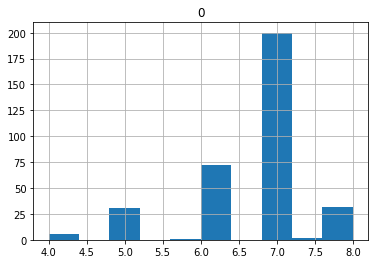

In [18]:
pd.DataFrame(preds).hist()

In [19]:
n_subjects = 21
n_films = 8
chans = ['Fz', 'F3', 'F7','C3', 'T7', 'Pz', 'P3','P7', 'O1', 'Oz', 'O2','P4', 'P8', 'Cz','C4', 'T8', 'F4', 'F8']
pred = [[0 for j in range(n_films)] for i in range(n_subjects)]
num_chans = [[0 for j in range(n_films)] for i in range(n_subjects)]
labels = [[0 for j in range(n_films)] for i in range(n_subjects)]
lbl = [[0 for j in range(n_films)] for i in range(n_subjects)]
channels = [[] for i in range(n_subjects)]
for i in range(len(preds)):
    pred[np.array(test_subj)[i] - 1][np.array(test_film)[i] - 1] += np.array(preds)[i]
    num_chans[np.array(test_subj)[i] - 1][np.array(test_film)[i] - 1] += 1
    labels[np.array(test_subj)[i] - 1][np.array(test_film)[i] - 1] += np.array(y_test_inv)[i]
    channels[np.array(test_subj)[i] - 1].append(chans[test_ch[i] - 1])
labels = np.array(labels).astype(np.float64) / np.array(num_chans).astype(np.float64)
pred = np.array(pred).astype(np.float64) / np.array(num_chans).astype(np.float64)
labels = np.nan_to_num(labels)
pred = np.nan_to_num(pred)
predicted = []
lbl = []
for i in range(len(labels)):
    if sum(labels[i]) != 0:
        for j in range(n_films):
            if labels[i][j] != 0:
                lbl.append(labels[i][j])  
                predicted.append(pred[i][j])

invalid value encountered in true_divide
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
invalid value encountered in true_divide


In [20]:
for [l, p] in zip(lbl, predicted):
    print('label : {:0.2f} predicted: {:0.2f} '.format(l, p))

label : 10.00 predicted: 7.47 
label : 8.00 predicted: 5.00 
label : 3.00 predicted: 7.00 
label : 6.00 predicted: 7.00 
label : 2.00 predicted: 7.00 
label : 7.00 predicted: 6.93 
label : 4.00 predicted: 7.65 
label : 7.00 predicted: 6.06 
label : 8.00 predicted: 7.00 
label : 8.00 predicted: 4.72 
label : 5.00 predicted: 7.13 
label : 10.00 predicted: 6.89 
label : 7.00 predicted: 7.22 
label : 7.00 predicted: 7.00 
label : 6.00 predicted: 7.39 
label : 7.00 predicted: 7.00 
label : 7.00 predicted: 6.00 
label : 6.00 predicted: 6.79 
label : 4.00 predicted: 6.00 
label : 8.00 predicted: 6.06 


In [22]:
models = ['CatboostRegressor']
metrics = ['MAPE', 'MAE', 'R2']
formes = ['inverted', 'average']
columns = [
    np.array([models[i] for i in range(1) for j in range(3) for k in range(2)]),
    np.array([metrics[j] for i in range(1) for j in range(3) for k in range(2)]),
    np.array([formes[k] for i in range(1) for j in range(3) for k in range(2)]),
]

In [23]:
from sklearn.metrics import mean_absolute_error, r2_score, mean_absolute_percentage_error

In [24]:
chans = ['Fz', 'F3', 'F7','C3', 'T7', 'Pz', 'P3','P7', 'O1', 'Oz', 'O2','P4', 'P8', 'Cz','C4', 'T8', 'F4', 'F8']

In [27]:
cols

['Beta_watch-relax',
 'Theta_watch-relax',
 'Beta/Alpha',
 'Beta/(Alpha + Theta)',
 'Alpha_ratio']

In [26]:

cols = [
    #'ShanEn',
    'Beta_watch-relax',
    #'Alpha_watch-relax',
    'Theta_watch-relax',
    'Beta/Alpha',
    'Beta/(Alpha + Theta)',
    #'Theta_ratio',
    #'Beta_ratio',
    'Alpha_ratio',
    #'Theta',
    #'Alpha',
    #'Beta',
    #'TotalAbsPow'
]

In [28]:
# 0.41
cols = [
    'ch',
    'Beta_watch-relax',
    'SCR_Peaks_Amplitude_Mean_watch',
    #'Alpha_watch-relax',
    'Theta_watch-relax',
    #'Beta/Alpha',
    'Beta/(Alpha + Theta)',
    'Theta_ratio',
    'Beta_ratio',
    #'Alpha_ratio',
    'Theta',
    #'Alpha',
    'Beta',
    #'TotalAbsPow'
]

In [81]:
cols = [
    'ch',
    'ShanEn',
    'DiffEn',
    'SpEn',
    'PFD',
    'Beta_watch-relax',
    'Alpha_watch-relax',
    'Theta_watch-relax',
    'Beta/Alpha',
    'Beta/(Alpha + Theta)',
    'Theta_ratio',
    'Beta_ratio',
    'Alpha_ratio',
    'Theta',
    #'Alpha',
    #'Beta',
    #'TotalAbsPow'
]

In [20]:
cols = [
    'ch',
    #'ECG_Rate_Mean_watch',
    #'SCR_Peaks_N_watch',
    #'SCR_Peaks_Amplitude_Mean_watch',
    #'SCR_Peaks_Amplitude_Mean_relax',
    #'SCR_Peaks_Amplitude_Mean_watch-relax',
    #'EMG_Activation_N_watch',
    'ShanEn',
    'Beta_watch-relax',
    'Alpha_watch-relax',
    #'Theta_watch-relax',
    'Beta/Alpha',
    #'Beta/(Alpha + Theta)',
    'Theta_ratio',
    #'Beta_ratio',
    #'Alpha_ratio',
    #'Theta',
    #'Alpha',
    #'Beta',
    #'TotalAbsPow'
]

In [30]:
result = pd.DataFrame()
grid_res = []
n_films = 8
n_subjects = 21
ab_pred = [0] * 8
for film in range(1, n_films + 1):
    df = pd.DataFrame(np.random.randn(1, 1 * 3 * 2), columns=columns)
    X_test = data_all.loc[(data_all['film'] == film)].reset_index(drop=True)
    X_train = data_all.loc[(data_all['film'] != film)].reset_index(drop=True)

    y_train = X_train['labels']
    y_test_inv = np.array(X_test['labels'])
    train_film = X_train['film']
    train_subj = X_train['Subj']
    train_ch = X_train['ch']
    test_film = X_test['film']
    test_subj = X_test['Subj']
    test_ch = np.array(X_test['ch'])
    
    X_train = X_train[cols]
    X_test = X_test[cols]
    
    qt_train = QuantileTransformer(output_distribution='normal',
                             copy=True)
    y_train = pd.DataFrame(qt_train.fit_transform(np.array(y_train).reshape(-1, 1)))
    y_test = pd.DataFrame(qt_train.transform(np.array(y_test_inv).reshape(-1, 1)))
    
    train_pool = Pool(X_train, y_train, cat_features=['ch'])
    test_pool = Pool(X_test, y_test, cat_features=['ch'])
    model = CatBoostRegressor()
    model.fit(train_pool)
    y_pred = model.predict(test_pool)
    preds = qt_train.inverse_transform(np.array(y_pred).reshape(-1, 1))
    df[('CatboostRegressor', 'R2', 'inverted')] = r2_score(preds, y_test_inv)
    df[('CatboostRegressor', 'MAPE', 'inverted')] = mean_absolute_percentage_error(preds, y_test_inv)
    df[('CatboostRegressor', 'MAE', 'inverted')] = mean_absolute_error(preds, y_test_inv)
    print(r2_score(preds, y_test))
    print(mean_absolute_percentage_error(preds, y_test))
    print(mean_absolute_error(preds, y_test))
    
    pred = [[0 for j in range(n_films)] for i in range(n_subjects)]
    num_chans = [[0 for j in range(n_films)] for i in range(n_subjects)]
    labels = [[0 for j in range(n_films)] for i in range(n_subjects)]
    lbl = [[0 for j in range(n_films)] for i in range(n_subjects)]
    channels = [[] for i in range(n_subjects)]
    for i in range(len(preds)):
        pred[np.array(test_subj)[i] - 1][np.array(test_film)[i] - 1] += preds[i]
        num_chans[np.array(test_subj)[i] - 1][np.array(test_film)[i] - 1] += 1
        labels[np.array(test_subj)[i] - 1][np.array(test_film)[i] - 1] += y_test_inv[i]
        channels[np.array(test_subj)[i] - 1].append(chans[test_ch[i] - 1])
    labels = np.array(labels).astype(np.float64) / np.array(num_chans).astype(np.float64)
    pred = np.array(pred).astype(np.float64) / np.array(num_chans).astype(np.float64)
    labels = np.nan_to_num(labels)
    pred = np.nan_to_num(pred)
    predicted = []
    lbl = []
    for i in range(len(labels)):
        if sum(labels[i]) != 0:
            for j in range(n_films):
                if labels[i][j] != 0:
                    lbl.append(labels[i][j])  
                    predicted.append(pred[i][j])
    for [l, p] in zip(lbl, predicted):
        print(l, p)
    ab_pred[film - 1] = np.mean(predicted) 
    df[('CatboostRegressor', 'R2', 'average')] = r2_score(lbl, predicted)
    df[('CatboostRegressor', 'MAPE', 'average')] = mean_absolute_percentage_error(lbl, predicted)
    df[('CatboostRegressor', 'MAE', 'average')] = mean_absolute_error(lbl, predicted)
    print(r2_score(lbl, predicted))
    print(mean_absolute_percentage_error(lbl, predicted))
    print(mean_absolute_error(lbl, predicted))
    result = pd.concat([result, df], axis=0)

Learning rate set to 0.047072
0:	learn: 1.6274215	total: 16.1ms	remaining: 16.1s
1:	learn: 1.6218557	total: 30.9ms	remaining: 15.4s
2:	learn: 1.6143884	total: 45.9ms	remaining: 15.2s
3:	learn: 1.6070987	total: 68.2ms	remaining: 17s
4:	learn: 1.5945013	total: 89.8ms	remaining: 17.9s
5:	learn: 1.5853646	total: 106ms	remaining: 17.6s
6:	learn: 1.5800680	total: 136ms	remaining: 19.3s
7:	learn: 1.5692432	total: 153ms	remaining: 19s
8:	learn: 1.5604603	total: 168ms	remaining: 18.5s
9:	learn: 1.5545108	total: 185ms	remaining: 18.3s
10:	learn: 1.5491662	total: 205ms	remaining: 18.4s
11:	learn: 1.5436214	total: 220ms	remaining: 18.1s
12:	learn: 1.5380094	total: 235ms	remaining: 17.9s
13:	learn: 1.5210169	total: 251ms	remaining: 17.7s
14:	learn: 1.5115891	total: 268ms	remaining: 17.6s
15:	learn: 1.5037889	total: 285ms	remaining: 17.5s
16:	learn: 1.4951364	total: 302ms	remaining: 17.4s
17:	learn: 1.4899231	total: 322ms	remaining: 17.6s
18:	learn: 1.4843186	total: 344ms	remaining: 17.7s
19:	learn:

168:	learn: 0.9819711	total: 3.33s	remaining: 16.4s
169:	learn: 0.9771649	total: 3.35s	remaining: 16.4s
170:	learn: 0.9753554	total: 3.37s	remaining: 16.3s
171:	learn: 0.9730420	total: 3.39s	remaining: 16.3s
172:	learn: 0.9723386	total: 3.41s	remaining: 16.3s
173:	learn: 0.9680571	total: 3.42s	remaining: 16.3s
174:	learn: 0.9625729	total: 3.44s	remaining: 16.2s
175:	learn: 0.9573085	total: 3.46s	remaining: 16.2s
176:	learn: 0.9544299	total: 3.48s	remaining: 16.2s
177:	learn: 0.9527318	total: 3.5s	remaining: 16.2s
178:	learn: 0.9499956	total: 3.52s	remaining: 16.1s
179:	learn: 0.9475124	total: 3.54s	remaining: 16.1s
180:	learn: 0.9460049	total: 3.56s	remaining: 16.1s
181:	learn: 0.9447663	total: 3.58s	remaining: 16.1s
182:	learn: 0.9426784	total: 3.59s	remaining: 16s
183:	learn: 0.9397282	total: 3.61s	remaining: 16s
184:	learn: 0.9368947	total: 3.63s	remaining: 16s
185:	learn: 0.9322582	total: 3.65s	remaining: 16s
186:	learn: 0.9316395	total: 3.66s	remaining: 15.9s
187:	learn: 0.9271167

330:	learn: 0.5976794	total: 6.72s	remaining: 13.6s
331:	learn: 0.5966525	total: 6.74s	remaining: 13.6s
332:	learn: 0.5937941	total: 6.77s	remaining: 13.6s
333:	learn: 0.5920670	total: 6.79s	remaining: 13.5s
334:	learn: 0.5888981	total: 6.81s	remaining: 13.5s
335:	learn: 0.5883838	total: 6.83s	remaining: 13.5s
336:	learn: 0.5871616	total: 6.85s	remaining: 13.5s
337:	learn: 0.5835128	total: 6.87s	remaining: 13.5s
338:	learn: 0.5825648	total: 6.89s	remaining: 13.4s
339:	learn: 0.5815070	total: 6.92s	remaining: 13.4s
340:	learn: 0.5797829	total: 6.95s	remaining: 13.4s
341:	learn: 0.5767421	total: 6.96s	remaining: 13.4s
342:	learn: 0.5755606	total: 6.99s	remaining: 13.4s
343:	learn: 0.5727867	total: 7.01s	remaining: 13.4s
344:	learn: 0.5702340	total: 7.03s	remaining: 13.3s
345:	learn: 0.5667826	total: 7.05s	remaining: 13.3s
346:	learn: 0.5643061	total: 7.07s	remaining: 13.3s
347:	learn: 0.5626710	total: 7.09s	remaining: 13.3s
348:	learn: 0.5621710	total: 7.12s	remaining: 13.3s
349:	learn: 

496:	learn: 0.4283879	total: 10.3s	remaining: 10.4s
497:	learn: 0.4278842	total: 10.3s	remaining: 10.4s
498:	learn: 0.4268748	total: 10.4s	remaining: 10.4s
499:	learn: 0.4260771	total: 10.4s	remaining: 10.4s
500:	learn: 0.4256105	total: 10.4s	remaining: 10.4s
501:	learn: 0.4247260	total: 10.4s	remaining: 10.3s
502:	learn: 0.4243272	total: 10.4s	remaining: 10.3s
503:	learn: 0.4232837	total: 10.5s	remaining: 10.3s
504:	learn: 0.4228581	total: 10.5s	remaining: 10.3s
505:	learn: 0.4221880	total: 10.5s	remaining: 10.3s
506:	learn: 0.4208383	total: 10.5s	remaining: 10.2s
507:	learn: 0.4200883	total: 10.5s	remaining: 10.2s
508:	learn: 0.4193123	total: 10.6s	remaining: 10.2s
509:	learn: 0.4183838	total: 10.6s	remaining: 10.2s
510:	learn: 0.4178503	total: 10.6s	remaining: 10.1s
511:	learn: 0.4173078	total: 10.6s	remaining: 10.1s
512:	learn: 0.4170428	total: 10.6s	remaining: 10.1s
513:	learn: 0.4158966	total: 10.7s	remaining: 10.1s
514:	learn: 0.4154680	total: 10.7s	remaining: 10.1s
515:	learn: 

661:	learn: 0.3385400	total: 13.9s	remaining: 7.12s
662:	learn: 0.3382478	total: 14s	remaining: 7.1s
663:	learn: 0.3379803	total: 14s	remaining: 7.08s
664:	learn: 0.3373160	total: 14s	remaining: 7.05s
665:	learn: 0.3371561	total: 14s	remaining: 7.03s
666:	learn: 0.3366276	total: 14.1s	remaining: 7.02s
667:	learn: 0.3363767	total: 14.1s	remaining: 7s
668:	learn: 0.3358452	total: 14.1s	remaining: 6.98s
669:	learn: 0.3357472	total: 14.2s	remaining: 6.98s
670:	learn: 0.3356233	total: 14.2s	remaining: 6.95s
671:	learn: 0.3355067	total: 14.2s	remaining: 6.93s
672:	learn: 0.3352701	total: 14.2s	remaining: 6.91s
673:	learn: 0.3351231	total: 14.2s	remaining: 6.89s
674:	learn: 0.3349987	total: 14.3s	remaining: 6.87s
675:	learn: 0.3347923	total: 14.3s	remaining: 6.84s
676:	learn: 0.3346459	total: 14.3s	remaining: 6.82s
677:	learn: 0.3342800	total: 14.3s	remaining: 6.8s
678:	learn: 0.3341134	total: 14.3s	remaining: 6.78s
679:	learn: 0.3337975	total: 14.3s	remaining: 6.75s
680:	learn: 0.3336818	tot

820:	learn: 0.2826934	total: 17.1s	remaining: 3.73s
821:	learn: 0.2823150	total: 17.1s	remaining: 3.71s
822:	learn: 0.2821667	total: 17.1s	remaining: 3.69s
823:	learn: 0.2818552	total: 17.2s	remaining: 3.67s
824:	learn: 0.2811794	total: 17.2s	remaining: 3.64s
825:	learn: 0.2808878	total: 17.2s	remaining: 3.62s
826:	learn: 0.2807922	total: 17.2s	remaining: 3.6s
827:	learn: 0.2806611	total: 17.2s	remaining: 3.58s
828:	learn: 0.2800314	total: 17.3s	remaining: 3.56s
829:	learn: 0.2798741	total: 17.3s	remaining: 3.54s
830:	learn: 0.2796118	total: 17.3s	remaining: 3.52s
831:	learn: 0.2792929	total: 17.3s	remaining: 3.49s
832:	learn: 0.2791835	total: 17.3s	remaining: 3.47s
833:	learn: 0.2787798	total: 17.3s	remaining: 3.45s
834:	learn: 0.2787088	total: 17.4s	remaining: 3.43s
835:	learn: 0.2784743	total: 17.4s	remaining: 3.41s
836:	learn: 0.2783542	total: 17.4s	remaining: 3.39s
837:	learn: 0.2782224	total: 17.4s	remaining: 3.37s
838:	learn: 0.2780086	total: 17.5s	remaining: 3.35s
839:	learn: 0

979:	learn: 0.2429376	total: 20.9s	remaining: 427ms
980:	learn: 0.2427312	total: 21s	remaining: 406ms
981:	learn: 0.2424913	total: 21s	remaining: 385ms
982:	learn: 0.2423772	total: 21s	remaining: 363ms
983:	learn: 0.2421116	total: 21s	remaining: 342ms
984:	learn: 0.2418172	total: 21s	remaining: 320ms
985:	learn: 0.2415541	total: 21.1s	remaining: 299ms
986:	learn: 0.2414808	total: 21.1s	remaining: 278ms
987:	learn: 0.2412018	total: 21.1s	remaining: 256ms
988:	learn: 0.2410361	total: 21.1s	remaining: 235ms
989:	learn: 0.2406902	total: 21.1s	remaining: 214ms
990:	learn: 0.2406217	total: 21.2s	remaining: 192ms
991:	learn: 0.2402238	total: 21.2s	remaining: 171ms
992:	learn: 0.2400902	total: 21.2s	remaining: 149ms
993:	learn: 0.2399926	total: 21.2s	remaining: 128ms
994:	learn: 0.2399621	total: 21.2s	remaining: 107ms
995:	learn: 0.2397709	total: 21.3s	remaining: 85.4ms
996:	learn: 0.2395731	total: 21.3s	remaining: 64ms
997:	learn: 0.2391794	total: 21.3s	remaining: 42.7ms
998:	learn: 0.2390929

invalid value encountered in true_divide
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
invalid value encountered in true_divide


10.0 7.3125
10.0 5.352941176470588
6.0 4.777777777777778
8.0 8.647058823529411
3.0 3.1666666666666665
7.0 4.769230769230769
9.0 8.235294117647058
5.0 7.888888888888889
8.0 5.555555555555555
3.0 3.7222222222222223
8.0 2.75
10.0 4.5
8.0 8.055555555555555
10.0 8.625
9.0 5.611111111111111
6.0 4.833333333333333
9.0 7.25
10.0 5.5
5.0 7.742089333930661
5.0 7.588235294117647
9.0 5.833333333333333
-0.6274713518343513
0.3135887394400761
2.3764114100215012
Learning rate set to 0.047035
0:	learn: 1.7677554	total: 22.7ms	remaining: 22.7s
1:	learn: 1.7553420	total: 40.9ms	remaining: 20.4s
2:	learn: 1.7433081	total: 61ms	remaining: 20.3s
3:	learn: 1.7336213	total: 85ms	remaining: 21.2s
4:	learn: 1.7213084	total: 107ms	remaining: 21.3s
5:	learn: 1.7101484	total: 128ms	remaining: 21.2s
6:	learn: 1.7007201	total: 152ms	remaining: 21.5s
7:	learn: 1.6882143	total: 175ms	remaining: 21.7s
8:	learn: 1.6804495	total: 198ms	remaining: 21.8s
9:	learn: 1.6707107	total: 230ms	remaining: 22.8s
10:	learn: 1.6616372

152:	learn: 1.1288740	total: 3.37s	remaining: 18.6s
153:	learn: 1.1274499	total: 3.39s	remaining: 18.6s
154:	learn: 1.1241400	total: 3.41s	remaining: 18.6s
155:	learn: 1.1207066	total: 3.43s	remaining: 18.6s
156:	learn: 1.1181649	total: 3.46s	remaining: 18.6s
157:	learn: 1.1146722	total: 3.48s	remaining: 18.5s
158:	learn: 1.1137127	total: 3.51s	remaining: 18.6s
159:	learn: 1.1108581	total: 3.54s	remaining: 18.6s
160:	learn: 1.1062666	total: 3.56s	remaining: 18.5s
161:	learn: 1.1016923	total: 3.58s	remaining: 18.5s
162:	learn: 1.0994847	total: 3.61s	remaining: 18.5s
163:	learn: 1.0981745	total: 3.64s	remaining: 18.6s
164:	learn: 1.0971567	total: 3.68s	remaining: 18.6s
165:	learn: 1.0955873	total: 3.7s	remaining: 18.6s
166:	learn: 1.0910421	total: 3.75s	remaining: 18.7s
167:	learn: 1.0845943	total: 3.77s	remaining: 18.7s
168:	learn: 1.0814623	total: 3.8s	remaining: 18.7s
169:	learn: 1.0753316	total: 3.82s	remaining: 18.7s
170:	learn: 1.0727314	total: 3.84s	remaining: 18.6s
171:	learn: 1.

316:	learn: 0.7180958	total: 7.24s	remaining: 15.6s
317:	learn: 0.7165921	total: 7.26s	remaining: 15.6s
318:	learn: 0.7132290	total: 7.29s	remaining: 15.6s
319:	learn: 0.7122981	total: 7.31s	remaining: 15.5s
320:	learn: 0.7114092	total: 7.33s	remaining: 15.5s
321:	learn: 0.7098164	total: 7.35s	remaining: 15.5s
322:	learn: 0.7068064	total: 7.38s	remaining: 15.5s
323:	learn: 0.7050876	total: 7.4s	remaining: 15.4s
324:	learn: 0.7041697	total: 7.42s	remaining: 15.4s
325:	learn: 0.7032949	total: 7.45s	remaining: 15.4s
326:	learn: 0.7027476	total: 7.47s	remaining: 15.4s
327:	learn: 0.7015631	total: 7.5s	remaining: 15.4s
328:	learn: 0.6996520	total: 7.52s	remaining: 15.3s
329:	learn: 0.6976363	total: 7.54s	remaining: 15.3s
330:	learn: 0.6954177	total: 7.56s	remaining: 15.3s
331:	learn: 0.6946215	total: 7.58s	remaining: 15.3s
332:	learn: 0.6938849	total: 7.6s	remaining: 15.2s
333:	learn: 0.6926877	total: 7.62s	remaining: 15.2s
334:	learn: 0.6916350	total: 7.64s	remaining: 15.2s
335:	learn: 0.6

479:	learn: 0.5204699	total: 10.6s	remaining: 11.5s
480:	learn: 0.5196109	total: 10.6s	remaining: 11.5s
481:	learn: 0.5186296	total: 10.7s	remaining: 11.5s
482:	learn: 0.5182489	total: 10.7s	remaining: 11.4s
483:	learn: 0.5169633	total: 10.7s	remaining: 11.4s
484:	learn: 0.5166511	total: 10.7s	remaining: 11.4s
485:	learn: 0.5162510	total: 10.7s	remaining: 11.4s
486:	learn: 0.5159214	total: 10.8s	remaining: 11.3s
487:	learn: 0.5153268	total: 10.8s	remaining: 11.3s
488:	learn: 0.5144583	total: 10.8s	remaining: 11.3s
489:	learn: 0.5139757	total: 10.8s	remaining: 11.3s
490:	learn: 0.5137239	total: 10.8s	remaining: 11.2s
491:	learn: 0.5130948	total: 10.9s	remaining: 11.2s
492:	learn: 0.5121976	total: 10.9s	remaining: 11.2s
493:	learn: 0.5116250	total: 10.9s	remaining: 11.2s
494:	learn: 0.5111886	total: 10.9s	remaining: 11.1s
495:	learn: 0.5108863	total: 10.9s	remaining: 11.1s
496:	learn: 0.5105302	total: 11s	remaining: 11.1s
497:	learn: 0.5102178	total: 11s	remaining: 11.1s
498:	learn: 0.50

647:	learn: 0.4150102	total: 14s	remaining: 7.58s
648:	learn: 0.4144748	total: 14s	remaining: 7.56s
649:	learn: 0.4142465	total: 14s	remaining: 7.54s
650:	learn: 0.4140622	total: 14s	remaining: 7.52s
651:	learn: 0.4129649	total: 14s	remaining: 7.49s
652:	learn: 0.4125435	total: 14.1s	remaining: 7.47s
653:	learn: 0.4122859	total: 14.1s	remaining: 7.45s
654:	learn: 0.4119768	total: 14.1s	remaining: 7.43s
655:	learn: 0.4117157	total: 14.1s	remaining: 7.41s
656:	learn: 0.4110236	total: 14.1s	remaining: 7.38s
657:	learn: 0.4108449	total: 14.2s	remaining: 7.36s
658:	learn: 0.4103694	total: 14.2s	remaining: 7.34s
659:	learn: 0.4099462	total: 14.2s	remaining: 7.32s
660:	learn: 0.4093141	total: 14.2s	remaining: 7.29s
661:	learn: 0.4087088	total: 14.2s	remaining: 7.27s
662:	learn: 0.4082840	total: 14.3s	remaining: 7.25s
663:	learn: 0.4077353	total: 14.3s	remaining: 7.22s
664:	learn: 0.4071744	total: 14.3s	remaining: 7.2s
665:	learn: 0.4070247	total: 14.3s	remaining: 7.18s
666:	learn: 0.4069375	t

808:	learn: 0.3494629	total: 17.1s	remaining: 4.04s
809:	learn: 0.3490909	total: 17.1s	remaining: 4.02s
810:	learn: 0.3486846	total: 17.2s	remaining: 4s
811:	learn: 0.3483870	total: 17.2s	remaining: 3.98s
812:	learn: 0.3473149	total: 17.2s	remaining: 3.96s
813:	learn: 0.3466973	total: 17.2s	remaining: 3.94s
814:	learn: 0.3462412	total: 17.3s	remaining: 3.92s
815:	learn: 0.3456080	total: 17.3s	remaining: 3.9s
816:	learn: 0.3454534	total: 17.3s	remaining: 3.87s
817:	learn: 0.3452176	total: 17.3s	remaining: 3.85s
818:	learn: 0.3448458	total: 17.3s	remaining: 3.83s
819:	learn: 0.3446125	total: 17.4s	remaining: 3.81s
820:	learn: 0.3443452	total: 17.4s	remaining: 3.79s
821:	learn: 0.3440551	total: 17.4s	remaining: 3.77s
822:	learn: 0.3436726	total: 17.4s	remaining: 3.75s
823:	learn: 0.3432359	total: 17.4s	remaining: 3.72s
824:	learn: 0.3428643	total: 17.5s	remaining: 3.7s
825:	learn: 0.3426014	total: 17.5s	remaining: 3.68s
826:	learn: 0.3421856	total: 17.5s	remaining: 3.66s
827:	learn: 0.342

973:	learn: 0.2996331	total: 20.7s	remaining: 553ms
974:	learn: 0.2994306	total: 20.7s	remaining: 532ms
975:	learn: 0.2992997	total: 20.8s	remaining: 511ms
976:	learn: 0.2990886	total: 20.8s	remaining: 490ms
977:	learn: 0.2989814	total: 20.8s	remaining: 468ms
978:	learn: 0.2988911	total: 20.8s	remaining: 447ms
979:	learn: 0.2986463	total: 20.9s	remaining: 426ms
980:	learn: 0.2985292	total: 20.9s	remaining: 405ms
981:	learn: 0.2984057	total: 20.9s	remaining: 384ms
982:	learn: 0.2980714	total: 20.9s	remaining: 362ms
983:	learn: 0.2975375	total: 21s	remaining: 341ms
984:	learn: 0.2973266	total: 21s	remaining: 320ms
985:	learn: 0.2971154	total: 21s	remaining: 298ms
986:	learn: 0.2969980	total: 21s	remaining: 277ms
987:	learn: 0.2968587	total: 21s	remaining: 256ms
988:	learn: 0.2967020	total: 21.1s	remaining: 234ms
989:	learn: 0.2965527	total: 21.1s	remaining: 213ms
990:	learn: 0.2962120	total: 21.1s	remaining: 192ms
991:	learn: 0.2958023	total: 21.1s	remaining: 170ms
992:	learn: 0.2955981	

invalid value encountered in true_divide
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
invalid value encountered in true_divide


6:	learn: 1.7912461	total: 148ms	remaining: 20.9s
7:	learn: 1.7822452	total: 170ms	remaining: 21.1s
8:	learn: 1.7742303	total: 189ms	remaining: 20.8s
9:	learn: 1.7638836	total: 207ms	remaining: 20.5s
10:	learn: 1.7582822	total: 229ms	remaining: 20.6s
11:	learn: 1.7499193	total: 248ms	remaining: 20.4s
12:	learn: 1.7390367	total: 265ms	remaining: 20.1s
13:	learn: 1.7318863	total: 336ms	remaining: 23.6s
14:	learn: 1.7237946	total: 358ms	remaining: 23.5s
15:	learn: 1.7155970	total: 376ms	remaining: 23.1s
16:	learn: 1.7067311	total: 396ms	remaining: 22.9s
17:	learn: 1.7028015	total: 415ms	remaining: 22.7s
18:	learn: 1.6975643	total: 434ms	remaining: 22.4s
19:	learn: 1.6911748	total: 454ms	remaining: 22.3s
20:	learn: 1.6816466	total: 473ms	remaining: 22.1s
21:	learn: 1.6762781	total: 492ms	remaining: 21.9s
22:	learn: 1.6709312	total: 510ms	remaining: 21.6s
23:	learn: 1.6644358	total: 548ms	remaining: 22.3s
24:	learn: 1.6595117	total: 570ms	remaining: 22.2s
25:	learn: 1.6499784	total: 590ms	r

169:	learn: 1.1715478	total: 3.5s	remaining: 17.1s
170:	learn: 1.1662989	total: 3.51s	remaining: 17s
171:	learn: 1.1654987	total: 3.54s	remaining: 17s
172:	learn: 1.1635771	total: 3.56s	remaining: 17s
173:	learn: 1.1627704	total: 3.57s	remaining: 17s
174:	learn: 1.1594789	total: 3.59s	remaining: 16.9s
175:	learn: 1.1585821	total: 3.61s	remaining: 16.9s
176:	learn: 1.1539659	total: 3.63s	remaining: 16.9s
177:	learn: 1.1534469	total: 3.64s	remaining: 16.8s
178:	learn: 1.1519839	total: 3.66s	remaining: 16.8s
179:	learn: 1.1475867	total: 3.68s	remaining: 16.8s
180:	learn: 1.1416316	total: 3.7s	remaining: 16.7s
181:	learn: 1.1381944	total: 3.72s	remaining: 16.7s
182:	learn: 1.1354590	total: 3.74s	remaining: 16.7s
183:	learn: 1.1311061	total: 3.75s	remaining: 16.6s
184:	learn: 1.1291503	total: 3.77s	remaining: 16.6s
185:	learn: 1.1230330	total: 3.79s	remaining: 16.6s
186:	learn: 1.1221607	total: 3.81s	remaining: 16.6s
187:	learn: 1.1215391	total: 3.83s	remaining: 16.6s
188:	learn: 1.1170858	

337:	learn: 0.7244465	total: 6.84s	remaining: 13.4s
338:	learn: 0.7232950	total: 6.86s	remaining: 13.4s
339:	learn: 0.7206532	total: 6.88s	remaining: 13.3s
340:	learn: 0.7194282	total: 6.9s	remaining: 13.3s
341:	learn: 0.7174605	total: 6.92s	remaining: 13.3s
342:	learn: 0.7168289	total: 6.95s	remaining: 13.3s
343:	learn: 0.7162329	total: 6.97s	remaining: 13.3s
344:	learn: 0.7151036	total: 7s	remaining: 13.3s
345:	learn: 0.7139882	total: 7.02s	remaining: 13.3s
346:	learn: 0.7127570	total: 7.06s	remaining: 13.3s
347:	learn: 0.7098067	total: 7.08s	remaining: 13.3s
348:	learn: 0.7091057	total: 7.13s	remaining: 13.3s
349:	learn: 0.7077671	total: 7.16s	remaining: 13.3s
350:	learn: 0.7072182	total: 7.18s	remaining: 13.3s
351:	learn: 0.7036550	total: 7.2s	remaining: 13.3s
352:	learn: 0.7026155	total: 7.22s	remaining: 13.2s
353:	learn: 0.7019629	total: 7.24s	remaining: 13.2s
354:	learn: 0.6978653	total: 7.27s	remaining: 13.2s
355:	learn: 0.6967352	total: 7.29s	remaining: 13.2s
356:	learn: 0.695

498:	learn: 0.5149232	total: 10.2s	remaining: 10.2s
499:	learn: 0.5142969	total: 10.2s	remaining: 10.2s
500:	learn: 0.5132175	total: 10.2s	remaining: 10.2s
501:	learn: 0.5123442	total: 10.3s	remaining: 10.2s
502:	learn: 0.5116920	total: 10.3s	remaining: 10.2s
503:	learn: 0.5113368	total: 10.3s	remaining: 10.1s
504:	learn: 0.5108504	total: 10.3s	remaining: 10.1s
505:	learn: 0.5103360	total: 10.3s	remaining: 10.1s
506:	learn: 0.5097961	total: 10.4s	remaining: 10.1s
507:	learn: 0.5092094	total: 10.4s	remaining: 10.1s
508:	learn: 0.5074371	total: 10.4s	remaining: 10s
509:	learn: 0.5068221	total: 10.4s	remaining: 10s
510:	learn: 0.5063715	total: 10.4s	remaining: 9.99s
511:	learn: 0.5046992	total: 10.5s	remaining: 9.97s
512:	learn: 0.5044170	total: 10.5s	remaining: 9.95s
513:	learn: 0.5041833	total: 10.5s	remaining: 9.92s
514:	learn: 0.5037410	total: 10.5s	remaining: 9.9s
515:	learn: 0.5031081	total: 10.5s	remaining: 9.88s
516:	learn: 0.5018069	total: 10.6s	remaining: 9.86s
517:	learn: 0.501

658:	learn: 0.4109355	total: 13.4s	remaining: 6.91s
659:	learn: 0.4107502	total: 13.4s	remaining: 6.89s
660:	learn: 0.4100849	total: 13.4s	remaining: 6.87s
661:	learn: 0.4098611	total: 13.4s	remaining: 6.85s
662:	learn: 0.4086485	total: 13.4s	remaining: 6.83s
663:	learn: 0.4069570	total: 13.4s	remaining: 6.8s
664:	learn: 0.4062474	total: 13.5s	remaining: 6.78s
665:	learn: 0.4060439	total: 13.5s	remaining: 6.76s
666:	learn: 0.4055935	total: 13.5s	remaining: 6.74s
667:	learn: 0.4052569	total: 13.5s	remaining: 6.72s
668:	learn: 0.4051421	total: 13.5s	remaining: 6.7s
669:	learn: 0.4048272	total: 13.6s	remaining: 6.68s
670:	learn: 0.4046616	total: 13.6s	remaining: 6.66s
671:	learn: 0.4044532	total: 13.6s	remaining: 6.63s
672:	learn: 0.4033112	total: 13.6s	remaining: 6.61s
673:	learn: 0.4030793	total: 13.6s	remaining: 6.59s
674:	learn: 0.4027296	total: 13.7s	remaining: 6.58s
675:	learn: 0.4017247	total: 13.7s	remaining: 6.55s
676:	learn: 0.4010783	total: 13.7s	remaining: 6.53s
677:	learn: 0.

819:	learn: 0.3383289	total: 16.5s	remaining: 3.63s
820:	learn: 0.3381644	total: 16.5s	remaining: 3.61s
821:	learn: 0.3380644	total: 16.6s	remaining: 3.59s
822:	learn: 0.3374785	total: 16.6s	remaining: 3.57s
823:	learn: 0.3370371	total: 16.6s	remaining: 3.55s
824:	learn: 0.3366478	total: 16.6s	remaining: 3.52s
825:	learn: 0.3365301	total: 16.6s	remaining: 3.5s
826:	learn: 0.3362518	total: 16.7s	remaining: 3.48s
827:	learn: 0.3358416	total: 16.7s	remaining: 3.46s
828:	learn: 0.3355403	total: 16.7s	remaining: 3.44s
829:	learn: 0.3353702	total: 16.7s	remaining: 3.42s
830:	learn: 0.3351577	total: 16.7s	remaining: 3.4s
831:	learn: 0.3349588	total: 16.8s	remaining: 3.38s
832:	learn: 0.3348393	total: 16.8s	remaining: 3.36s
833:	learn: 0.3344705	total: 16.8s	remaining: 3.34s
834:	learn: 0.3337315	total: 16.8s	remaining: 3.32s
835:	learn: 0.3335296	total: 16.8s	remaining: 3.3s
836:	learn: 0.3329419	total: 16.9s	remaining: 3.28s
837:	learn: 0.3326814	total: 16.9s	remaining: 3.26s
838:	learn: 0.3

981:	learn: 0.2898154	total: 20.2s	remaining: 370ms
982:	learn: 0.2896904	total: 20.2s	remaining: 349ms
983:	learn: 0.2895794	total: 20.2s	remaining: 329ms
984:	learn: 0.2890369	total: 20.2s	remaining: 308ms
985:	learn: 0.2884821	total: 20.3s	remaining: 288ms
986:	learn: 0.2883985	total: 20.3s	remaining: 267ms
987:	learn: 0.2880782	total: 20.3s	remaining: 247ms
988:	learn: 0.2879562	total: 20.3s	remaining: 226ms
989:	learn: 0.2878080	total: 20.3s	remaining: 205ms
990:	learn: 0.2877349	total: 20.4s	remaining: 185ms
991:	learn: 0.2875227	total: 20.4s	remaining: 164ms
992:	learn: 0.2872335	total: 20.4s	remaining: 144ms
993:	learn: 0.2869532	total: 20.5s	remaining: 124ms
994:	learn: 0.2868014	total: 20.5s	remaining: 103ms
995:	learn: 0.2864413	total: 20.5s	remaining: 82.5ms
996:	learn: 0.2860311	total: 20.6s	remaining: 61.9ms
997:	learn: 0.2858998	total: 20.6s	remaining: 41.3ms
998:	learn: 0.2856577	total: 20.6s	remaining: 20.6ms
999:	learn: 0.2853927	total: 20.6s	remaining: 0us
-8.0375363

invalid value encountered in true_divide
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
invalid value encountered in true_divide


1:	learn: 1.7154228	total: 58.5ms	remaining: 29.2s
2:	learn: 1.7039206	total: 76.5ms	remaining: 25.4s
3:	learn: 1.6939117	total: 91.8ms	remaining: 22.9s
4:	learn: 1.6850210	total: 112ms	remaining: 22.4s
5:	learn: 1.6737455	total: 134ms	remaining: 22.2s
6:	learn: 1.6677152	total: 154ms	remaining: 21.8s
7:	learn: 1.6618804	total: 169ms	remaining: 20.9s
8:	learn: 1.6515773	total: 192ms	remaining: 21.1s
9:	learn: 1.6467587	total: 210ms	remaining: 20.8s
10:	learn: 1.6374003	total: 228ms	remaining: 20.5s
11:	learn: 1.6266677	total: 263ms	remaining: 21.7s
12:	learn: 1.6177336	total: 288ms	remaining: 21.9s
13:	learn: 1.6122072	total: 310ms	remaining: 21.8s
14:	learn: 1.6032589	total: 330ms	remaining: 21.7s
15:	learn: 1.5959818	total: 348ms	remaining: 21.4s
16:	learn: 1.5926606	total: 366ms	remaining: 21.2s
17:	learn: 1.5867208	total: 389ms	remaining: 21.2s
18:	learn: 1.5763610	total: 410ms	remaining: 21.2s
19:	learn: 1.5717517	total: 429ms	remaining: 21s
20:	learn: 1.5633227	total: 454ms	remai

163:	learn: 1.1506756	total: 3.66s	remaining: 18.6s
164:	learn: 1.1493482	total: 3.68s	remaining: 18.6s
165:	learn: 1.1453092	total: 3.7s	remaining: 18.6s
166:	learn: 1.1414255	total: 3.72s	remaining: 18.5s
167:	learn: 1.1392586	total: 3.74s	remaining: 18.5s
168:	learn: 1.1387148	total: 3.76s	remaining: 18.5s
169:	learn: 1.1377075	total: 3.77s	remaining: 18.4s
170:	learn: 1.1318055	total: 3.79s	remaining: 18.4s
171:	learn: 1.1311075	total: 3.81s	remaining: 18.4s
172:	learn: 1.1232538	total: 3.85s	remaining: 18.4s
173:	learn: 1.1220033	total: 3.87s	remaining: 18.4s
174:	learn: 1.1211222	total: 3.89s	remaining: 18.4s
175:	learn: 1.1150128	total: 3.91s	remaining: 18.3s
176:	learn: 1.1133279	total: 3.93s	remaining: 18.3s
177:	learn: 1.1086366	total: 3.95s	remaining: 18.2s
178:	learn: 1.1042653	total: 3.97s	remaining: 18.2s
179:	learn: 1.1032984	total: 3.99s	remaining: 18.2s
180:	learn: 1.0986844	total: 4s	remaining: 18.1s
181:	learn: 1.0948784	total: 4.03s	remaining: 18.1s
182:	learn: 1.09

322:	learn: 0.7007417	total: 6.84s	remaining: 14.3s
323:	learn: 0.6996459	total: 6.86s	remaining: 14.3s
324:	learn: 0.6991222	total: 6.88s	remaining: 14.3s
325:	learn: 0.6985660	total: 6.9s	remaining: 14.3s
326:	learn: 0.6981309	total: 6.92s	remaining: 14.2s
327:	learn: 0.6961812	total: 6.94s	remaining: 14.2s
328:	learn: 0.6952502	total: 6.96s	remaining: 14.2s
329:	learn: 0.6939024	total: 6.97s	remaining: 14.2s
330:	learn: 0.6916908	total: 6.99s	remaining: 14.1s
331:	learn: 0.6887943	total: 7.03s	remaining: 14.1s
332:	learn: 0.6883256	total: 7.05s	remaining: 14.1s
333:	learn: 0.6872876	total: 7.07s	remaining: 14.1s
334:	learn: 0.6866685	total: 7.09s	remaining: 14.1s
335:	learn: 0.6854001	total: 7.11s	remaining: 14s
336:	learn: 0.6835470	total: 7.13s	remaining: 14s
337:	learn: 0.6826737	total: 7.14s	remaining: 14s
338:	learn: 0.6803808	total: 7.17s	remaining: 14s
339:	learn: 0.6799651	total: 7.19s	remaining: 14s
340:	learn: 0.6790162	total: 7.21s	remaining: 13.9s
341:	learn: 0.6775489	t

487:	learn: 0.5176857	total: 10.2s	remaining: 10.7s
488:	learn: 0.5162066	total: 10.3s	remaining: 10.7s
489:	learn: 0.5136520	total: 10.3s	remaining: 10.7s
490:	learn: 0.5123384	total: 10.3s	remaining: 10.7s
491:	learn: 0.5117909	total: 10.3s	remaining: 10.7s
492:	learn: 0.5114936	total: 10.3s	remaining: 10.6s
493:	learn: 0.5109265	total: 10.4s	remaining: 10.6s
494:	learn: 0.5104775	total: 10.4s	remaining: 10.6s
495:	learn: 0.5100267	total: 10.4s	remaining: 10.6s
496:	learn: 0.5097126	total: 10.4s	remaining: 10.5s
497:	learn: 0.5094344	total: 10.4s	remaining: 10.5s
498:	learn: 0.5073859	total: 10.4s	remaining: 10.5s
499:	learn: 0.5070468	total: 10.5s	remaining: 10.5s
500:	learn: 0.5064650	total: 10.5s	remaining: 10.5s
501:	learn: 0.5062358	total: 10.5s	remaining: 10.4s
502:	learn: 0.5059165	total: 10.5s	remaining: 10.4s
503:	learn: 0.5057245	total: 10.6s	remaining: 10.4s
504:	learn: 0.5052816	total: 10.6s	remaining: 10.4s
505:	learn: 0.5043482	total: 10.6s	remaining: 10.3s
506:	learn: 

650:	learn: 0.4195716	total: 13.5s	remaining: 7.25s
651:	learn: 0.4181290	total: 13.6s	remaining: 7.24s
652:	learn: 0.4175095	total: 13.6s	remaining: 7.21s
653:	learn: 0.4169722	total: 13.6s	remaining: 7.19s
654:	learn: 0.4156580	total: 13.6s	remaining: 7.17s
655:	learn: 0.4153971	total: 13.6s	remaining: 7.15s
656:	learn: 0.4145367	total: 13.7s	remaining: 7.13s
657:	learn: 0.4143316	total: 13.7s	remaining: 7.11s
658:	learn: 0.4139539	total: 13.7s	remaining: 7.08s
659:	learn: 0.4137759	total: 13.7s	remaining: 7.06s
660:	learn: 0.4132998	total: 13.7s	remaining: 7.04s
661:	learn: 0.4127455	total: 13.7s	remaining: 7.02s
662:	learn: 0.4122625	total: 13.8s	remaining: 7s
663:	learn: 0.4111862	total: 13.8s	remaining: 6.98s
664:	learn: 0.4108752	total: 13.8s	remaining: 6.96s
665:	learn: 0.4099547	total: 13.8s	remaining: 6.93s
666:	learn: 0.4095751	total: 13.8s	remaining: 6.91s
667:	learn: 0.4087329	total: 13.9s	remaining: 6.89s
668:	learn: 0.4080292	total: 13.9s	remaining: 6.87s
669:	learn: 0.4

810:	learn: 0.3504894	total: 16.7s	remaining: 3.88s
811:	learn: 0.3500058	total: 16.7s	remaining: 3.86s
812:	learn: 0.3496558	total: 16.7s	remaining: 3.84s
813:	learn: 0.3492416	total: 16.7s	remaining: 3.82s
814:	learn: 0.3491052	total: 16.7s	remaining: 3.8s
815:	learn: 0.3487843	total: 16.8s	remaining: 3.78s
816:	learn: 0.3482853	total: 16.8s	remaining: 3.76s
817:	learn: 0.3478711	total: 16.8s	remaining: 3.74s
818:	learn: 0.3475851	total: 16.8s	remaining: 3.72s
819:	learn: 0.3475490	total: 16.8s	remaining: 3.7s
820:	learn: 0.3466118	total: 16.9s	remaining: 3.67s
821:	learn: 0.3462184	total: 16.9s	remaining: 3.65s
822:	learn: 0.3460848	total: 16.9s	remaining: 3.63s
823:	learn: 0.3459589	total: 16.9s	remaining: 3.61s
824:	learn: 0.3456844	total: 16.9s	remaining: 3.59s
825:	learn: 0.3455420	total: 16.9s	remaining: 3.57s
826:	learn: 0.3454831	total: 17s	remaining: 3.55s
827:	learn: 0.3452949	total: 17s	remaining: 3.53s
828:	learn: 0.3452161	total: 17s	remaining: 3.51s
829:	learn: 0.345176

975:	learn: 0.2994132	total: 19.8s	remaining: 487ms
976:	learn: 0.2991477	total: 19.8s	remaining: 466ms
977:	learn: 0.2989672	total: 19.8s	remaining: 446ms
978:	learn: 0.2987721	total: 19.9s	remaining: 426ms
979:	learn: 0.2982802	total: 19.9s	remaining: 406ms
980:	learn: 0.2978998	total: 19.9s	remaining: 385ms
981:	learn: 0.2977268	total: 19.9s	remaining: 365ms
982:	learn: 0.2975734	total: 19.9s	remaining: 345ms
983:	learn: 0.2970795	total: 19.9s	remaining: 324ms
984:	learn: 0.2969683	total: 20s	remaining: 304ms
985:	learn: 0.2967809	total: 20s	remaining: 284ms
986:	learn: 0.2966420	total: 20s	remaining: 263ms
987:	learn: 0.2965343	total: 20s	remaining: 243ms
988:	learn: 0.2962539	total: 20s	remaining: 223ms
989:	learn: 0.2955029	total: 20.1s	remaining: 203ms
990:	learn: 0.2954487	total: 20.1s	remaining: 182ms
991:	learn: 0.2951353	total: 20.1s	remaining: 162ms
992:	learn: 0.2948729	total: 20.1s	remaining: 142ms
993:	learn: 0.2944437	total: 20.1s	remaining: 122ms
994:	learn: 0.2943468	

invalid value encountered in true_divide
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
invalid value encountered in true_divide


4:	learn: 1.6276897	total: 85.7ms	remaining: 17s
5:	learn: 1.6194972	total: 107ms	remaining: 17.7s
6:	learn: 1.6105360	total: 124ms	remaining: 17.6s
7:	learn: 1.6004648	total: 144ms	remaining: 17.9s
8:	learn: 1.5921965	total: 166ms	remaining: 18.2s
9:	learn: 1.5815100	total: 184ms	remaining: 18.2s
10:	learn: 1.5727254	total: 201ms	remaining: 18.1s
11:	learn: 1.5627892	total: 218ms	remaining: 17.9s
12:	learn: 1.5571890	total: 237ms	remaining: 18s
13:	learn: 1.5486803	total: 254ms	remaining: 17.9s
14:	learn: 1.5409624	total: 276ms	remaining: 18.1s
15:	learn: 1.5325220	total: 297ms	remaining: 18.3s
16:	learn: 1.5248891	total: 322ms	remaining: 18.6s
17:	learn: 1.5152722	total: 339ms	remaining: 18.5s
18:	learn: 1.5079320	total: 357ms	remaining: 18.4s
19:	learn: 1.5024266	total: 374ms	remaining: 18.3s
20:	learn: 1.4973394	total: 391ms	remaining: 18.2s
21:	learn: 1.4893599	total: 409ms	remaining: 18.2s
22:	learn: 1.4838507	total: 438ms	remaining: 18.6s
23:	learn: 1.4781387	total: 456ms	remain

170:	learn: 1.0647212	total: 3.21s	remaining: 15.6s
171:	learn: 1.0642242	total: 3.23s	remaining: 15.6s
172:	learn: 1.0567029	total: 3.26s	remaining: 15.6s
173:	learn: 1.0514232	total: 3.28s	remaining: 15.6s
174:	learn: 1.0469197	total: 3.3s	remaining: 15.6s
175:	learn: 1.0397490	total: 3.32s	remaining: 15.6s
176:	learn: 1.0341612	total: 3.34s	remaining: 15.5s
177:	learn: 1.0323018	total: 3.36s	remaining: 15.5s
178:	learn: 1.0300051	total: 3.38s	remaining: 15.5s
179:	learn: 1.0271652	total: 3.39s	remaining: 15.4s
180:	learn: 1.0261205	total: 3.41s	remaining: 15.4s
181:	learn: 1.0241577	total: 3.43s	remaining: 15.4s
182:	learn: 1.0199565	total: 3.45s	remaining: 15.4s
183:	learn: 1.0156007	total: 3.48s	remaining: 15.4s
184:	learn: 1.0112023	total: 3.5s	remaining: 15.4s
185:	learn: 1.0074957	total: 3.52s	remaining: 15.4s
186:	learn: 1.0049862	total: 3.54s	remaining: 15.4s
187:	learn: 1.0032698	total: 3.56s	remaining: 15.4s
188:	learn: 1.0010087	total: 3.57s	remaining: 15.3s
189:	learn: 0.

335:	learn: 0.6488220	total: 6.28s	remaining: 12.4s
336:	learn: 0.6473670	total: 6.3s	remaining: 12.4s
337:	learn: 0.6449121	total: 6.31s	remaining: 12.4s
338:	learn: 0.6420107	total: 6.33s	remaining: 12.3s
339:	learn: 0.6414238	total: 6.35s	remaining: 12.3s
340:	learn: 0.6400930	total: 6.37s	remaining: 12.3s
341:	learn: 0.6390633	total: 6.38s	remaining: 12.3s
342:	learn: 0.6384804	total: 6.4s	remaining: 12.3s
343:	learn: 0.6370660	total: 6.42s	remaining: 12.2s
344:	learn: 0.6364545	total: 6.44s	remaining: 12.2s
345:	learn: 0.6355130	total: 6.46s	remaining: 12.2s
346:	learn: 0.6350351	total: 6.47s	remaining: 12.2s
347:	learn: 0.6342384	total: 6.5s	remaining: 12.2s
348:	learn: 0.6334550	total: 6.51s	remaining: 12.1s
349:	learn: 0.6326720	total: 6.53s	remaining: 12.1s
350:	learn: 0.6318065	total: 6.55s	remaining: 12.1s
351:	learn: 0.6311798	total: 6.57s	remaining: 12.1s
352:	learn: 0.6304163	total: 6.58s	remaining: 12.1s
353:	learn: 0.6283243	total: 6.6s	remaining: 12.1s
354:	learn: 0.62

504:	learn: 0.4753005	total: 9.41s	remaining: 9.22s
505:	learn: 0.4748331	total: 9.43s	remaining: 9.2s
506:	learn: 0.4739619	total: 9.45s	remaining: 9.18s
507:	learn: 0.4731531	total: 9.46s	remaining: 9.16s
508:	learn: 0.4719612	total: 9.48s	remaining: 9.15s
509:	learn: 0.4712520	total: 9.5s	remaining: 9.13s
510:	learn: 0.4708209	total: 9.52s	remaining: 9.11s
511:	learn: 0.4699709	total: 9.54s	remaining: 9.09s
512:	learn: 0.4693613	total: 9.55s	remaining: 9.07s
513:	learn: 0.4681681	total: 9.57s	remaining: 9.05s
514:	learn: 0.4676174	total: 9.59s	remaining: 9.03s
515:	learn: 0.4670787	total: 9.61s	remaining: 9.01s
516:	learn: 0.4663805	total: 9.63s	remaining: 8.99s
517:	learn: 0.4659915	total: 9.65s	remaining: 8.97s
518:	learn: 0.4657995	total: 9.66s	remaining: 8.96s
519:	learn: 0.4655379	total: 9.68s	remaining: 8.94s
520:	learn: 0.4651788	total: 9.7s	remaining: 8.92s
521:	learn: 0.4641929	total: 9.72s	remaining: 8.9s
522:	learn: 0.4640145	total: 9.74s	remaining: 8.89s
523:	learn: 0.46

672:	learn: 0.3754424	total: 12.5s	remaining: 6.07s
673:	learn: 0.3748134	total: 12.5s	remaining: 6.05s
674:	learn: 0.3741155	total: 12.5s	remaining: 6.04s
675:	learn: 0.3738166	total: 12.6s	remaining: 6.02s
676:	learn: 0.3735199	total: 12.6s	remaining: 6s
677:	learn: 0.3724247	total: 12.6s	remaining: 5.98s
678:	learn: 0.3717852	total: 12.6s	remaining: 5.96s
679:	learn: 0.3715209	total: 12.6s	remaining: 5.94s
680:	learn: 0.3713774	total: 12.6s	remaining: 5.92s
681:	learn: 0.3712531	total: 12.7s	remaining: 5.9s
682:	learn: 0.3704822	total: 12.7s	remaining: 5.88s
683:	learn: 0.3700552	total: 12.7s	remaining: 5.86s
684:	learn: 0.3695618	total: 12.7s	remaining: 5.85s
685:	learn: 0.3694489	total: 12.7s	remaining: 5.83s
686:	learn: 0.3684720	total: 12.8s	remaining: 5.82s
687:	learn: 0.3675719	total: 12.8s	remaining: 5.8s
688:	learn: 0.3664124	total: 12.8s	remaining: 5.78s
689:	learn: 0.3653225	total: 12.8s	remaining: 5.76s
690:	learn: 0.3645138	total: 12.8s	remaining: 5.74s
691:	learn: 0.363

832:	learn: 0.3147897	total: 15.5s	remaining: 3.1s
833:	learn: 0.3144201	total: 15.5s	remaining: 3.08s
834:	learn: 0.3140912	total: 15.5s	remaining: 3.07s
835:	learn: 0.3140219	total: 15.5s	remaining: 3.05s
836:	learn: 0.3135593	total: 15.6s	remaining: 3.03s
837:	learn: 0.3132959	total: 15.6s	remaining: 3.01s
838:	learn: 0.3129004	total: 15.6s	remaining: 2.99s
839:	learn: 0.3122822	total: 15.6s	remaining: 2.97s
840:	learn: 0.3121013	total: 15.6s	remaining: 2.95s
841:	learn: 0.3115661	total: 15.6s	remaining: 2.94s
842:	learn: 0.3112198	total: 15.7s	remaining: 2.92s
843:	learn: 0.3105551	total: 15.7s	remaining: 2.9s
844:	learn: 0.3101355	total: 15.7s	remaining: 2.88s
845:	learn: 0.3096178	total: 15.7s	remaining: 2.86s
846:	learn: 0.3089791	total: 15.7s	remaining: 2.84s
847:	learn: 0.3086127	total: 15.8s	remaining: 2.82s
848:	learn: 0.3082316	total: 15.8s	remaining: 2.81s
849:	learn: 0.3077453	total: 15.8s	remaining: 2.79s
850:	learn: 0.3075554	total: 15.8s	remaining: 2.77s
851:	learn: 0.

invalid value encountered in true_divide
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
invalid value encountered in true_divide


9.0 3.8125
7.0 6.9411764705882355
5.0 4.611111111111111
5.0 2.6470588235294117
7.0 3.2777777777777777
5.0 4.923076923076923
9.0 10.0
3.0 6.833333333333333
7.0 8.277777777777779
1.0 5.333333333333333
8.0 6.666666666666667
10.0 5.703182065402259
3.0 7.555555555555555
1.0 5.352941176470588
7.0 7.944444444444445
6.0 10.0
10.0 7.333333333333333
7.0 8.4
8.0 7.722222222222222
9.0 1.0
-0.6545629972851137
0.8122362024839248
2.7029640113603546
Learning rate set to 0.047075
0:	learn: 1.8573429	total: 16.4ms	remaining: 16.4s
1:	learn: 1.8488154	total: 31.6ms	remaining: 15.8s
2:	learn: 1.8390686	total: 49.3ms	remaining: 16.4s
3:	learn: 1.8252029	total: 66.2ms	remaining: 16.5s
4:	learn: 1.8146311	total: 84.1ms	remaining: 16.7s
5:	learn: 1.8109499	total: 101ms	remaining: 16.7s
6:	learn: 1.8050338	total: 118ms	remaining: 16.7s
7:	learn: 1.7953750	total: 138ms	remaining: 17.1s
8:	learn: 1.7893032	total: 154ms	remaining: 17s
9:	learn: 1.7803691	total: 175ms	remaining: 17.3s
10:	learn: 1.7679286	total: 1

157:	learn: 1.2531712	total: 2.88s	remaining: 15.4s
158:	learn: 1.2492468	total: 2.9s	remaining: 15.3s
159:	learn: 1.2470200	total: 2.92s	remaining: 15.3s
160:	learn: 1.2450671	total: 2.94s	remaining: 15.3s
161:	learn: 1.2408506	total: 2.95s	remaining: 15.3s
162:	learn: 1.2391258	total: 2.97s	remaining: 15.2s
163:	learn: 1.2379488	total: 2.99s	remaining: 15.2s
164:	learn: 1.2376009	total: 3.01s	remaining: 15.2s
165:	learn: 1.2366230	total: 3.02s	remaining: 15.2s
166:	learn: 1.2350166	total: 3.04s	remaining: 15.2s
167:	learn: 1.2300761	total: 3.06s	remaining: 15.2s
168:	learn: 1.2280279	total: 3.08s	remaining: 15.1s
169:	learn: 1.2241387	total: 3.1s	remaining: 15.1s
170:	learn: 1.2175666	total: 3.12s	remaining: 15.1s
171:	learn: 1.2155433	total: 3.15s	remaining: 15.2s
172:	learn: 1.2134828	total: 3.17s	remaining: 15.2s
173:	learn: 1.2086164	total: 3.19s	remaining: 15.2s
174:	learn: 1.2060650	total: 3.21s	remaining: 15.1s
175:	learn: 1.2043530	total: 3.23s	remaining: 15.1s
176:	learn: 1.

316:	learn: 0.7920318	total: 5.94s	remaining: 12.8s
317:	learn: 0.7905898	total: 5.96s	remaining: 12.8s
318:	learn: 0.7885653	total: 5.98s	remaining: 12.8s
319:	learn: 0.7874517	total: 6s	remaining: 12.7s
320:	learn: 0.7861698	total: 6.02s	remaining: 12.7s
321:	learn: 0.7839149	total: 6.04s	remaining: 12.7s
322:	learn: 0.7811185	total: 6.05s	remaining: 12.7s
323:	learn: 0.7789227	total: 6.07s	remaining: 12.7s
324:	learn: 0.7782029	total: 6.09s	remaining: 12.7s
325:	learn: 0.7775757	total: 6.11s	remaining: 12.6s
326:	learn: 0.7764921	total: 6.13s	remaining: 12.6s
327:	learn: 0.7740014	total: 6.15s	remaining: 12.6s
328:	learn: 0.7729424	total: 6.17s	remaining: 12.6s
329:	learn: 0.7703771	total: 6.18s	remaining: 12.6s
330:	learn: 0.7686561	total: 6.2s	remaining: 12.5s
331:	learn: 0.7658689	total: 6.22s	remaining: 12.5s
332:	learn: 0.7646626	total: 6.24s	remaining: 12.5s
333:	learn: 0.7622433	total: 6.25s	remaining: 12.5s
334:	learn: 0.7611221	total: 6.27s	remaining: 12.5s
335:	learn: 0.76

485:	learn: 0.5706798	total: 9.24s	remaining: 9.77s
486:	learn: 0.5704017	total: 9.25s	remaining: 9.75s
487:	learn: 0.5698959	total: 9.28s	remaining: 9.73s
488:	learn: 0.5690324	total: 9.29s	remaining: 9.71s
489:	learn: 0.5679862	total: 9.32s	remaining: 9.7s
490:	learn: 0.5678743	total: 9.34s	remaining: 9.68s
491:	learn: 0.5669290	total: 9.38s	remaining: 9.69s
492:	learn: 0.5660789	total: 9.4s	remaining: 9.67s
493:	learn: 0.5645190	total: 9.43s	remaining: 9.66s
494:	learn: 0.5641369	total: 9.45s	remaining: 9.64s
495:	learn: 0.5637645	total: 9.47s	remaining: 9.63s
496:	learn: 0.5625740	total: 9.49s	remaining: 9.61s
497:	learn: 0.5621593	total: 9.51s	remaining: 9.59s
498:	learn: 0.5604593	total: 9.53s	remaining: 9.57s
499:	learn: 0.5597007	total: 9.55s	remaining: 9.55s
500:	learn: 0.5589722	total: 9.57s	remaining: 9.53s
501:	learn: 0.5571736	total: 9.59s	remaining: 9.51s
502:	learn: 0.5564955	total: 9.61s	remaining: 9.49s
503:	learn: 0.5556089	total: 9.62s	remaining: 9.47s
504:	learn: 0.

651:	learn: 0.4552145	total: 12.3s	remaining: 6.58s
652:	learn: 0.4546938	total: 12.3s	remaining: 6.56s
653:	learn: 0.4540745	total: 12.4s	remaining: 6.54s
654:	learn: 0.4537498	total: 12.4s	remaining: 6.52s
655:	learn: 0.4535993	total: 12.4s	remaining: 6.5s
656:	learn: 0.4532407	total: 12.4s	remaining: 6.48s
657:	learn: 0.4528202	total: 12.4s	remaining: 6.46s
658:	learn: 0.4526785	total: 12.5s	remaining: 6.45s
659:	learn: 0.4519548	total: 12.5s	remaining: 6.43s
660:	learn: 0.4511120	total: 12.5s	remaining: 6.41s
661:	learn: 0.4498566	total: 12.5s	remaining: 6.39s
662:	learn: 0.4494218	total: 12.5s	remaining: 6.37s
663:	learn: 0.4487431	total: 12.6s	remaining: 6.35s
664:	learn: 0.4483859	total: 12.6s	remaining: 6.33s
665:	learn: 0.4479134	total: 12.6s	remaining: 6.32s
666:	learn: 0.4471209	total: 12.6s	remaining: 6.29s
667:	learn: 0.4469320	total: 12.6s	remaining: 6.28s
668:	learn: 0.4467372	total: 12.6s	remaining: 6.26s
669:	learn: 0.4460564	total: 12.7s	remaining: 6.24s
670:	learn: 0

820:	learn: 0.3786596	total: 15.4s	remaining: 3.37s
821:	learn: 0.3781762	total: 15.5s	remaining: 3.35s
822:	learn: 0.3777628	total: 15.5s	remaining: 3.33s
823:	learn: 0.3775531	total: 15.5s	remaining: 3.31s
824:	learn: 0.3772341	total: 15.5s	remaining: 3.29s
825:	learn: 0.3768146	total: 15.5s	remaining: 3.27s
826:	learn: 0.3766129	total: 15.6s	remaining: 3.25s
827:	learn: 0.3765027	total: 15.6s	remaining: 3.23s
828:	learn: 0.3763767	total: 15.6s	remaining: 3.21s
829:	learn: 0.3761393	total: 15.6s	remaining: 3.2s
830:	learn: 0.3755757	total: 15.6s	remaining: 3.18s
831:	learn: 0.3747046	total: 15.6s	remaining: 3.16s
832:	learn: 0.3745079	total: 15.7s	remaining: 3.14s
833:	learn: 0.3735283	total: 15.7s	remaining: 3.12s
834:	learn: 0.3734385	total: 15.7s	remaining: 3.1s
835:	learn: 0.3730348	total: 15.7s	remaining: 3.08s
836:	learn: 0.3726084	total: 15.7s	remaining: 3.06s
837:	learn: 0.3725086	total: 15.8s	remaining: 3.04s
838:	learn: 0.3717788	total: 15.8s	remaining: 3.03s
839:	learn: 0.

986:	learn: 0.3261580	total: 18.5s	remaining: 244ms
987:	learn: 0.3257718	total: 18.5s	remaining: 225ms
988:	learn: 0.3257179	total: 18.6s	remaining: 206ms
989:	learn: 0.3252181	total: 18.6s	remaining: 188ms
990:	learn: 0.3251254	total: 18.6s	remaining: 169ms
991:	learn: 0.3249176	total: 18.6s	remaining: 150ms
992:	learn: 0.3247517	total: 18.6s	remaining: 131ms
993:	learn: 0.3243229	total: 18.6s	remaining: 113ms
994:	learn: 0.3241597	total: 18.7s	remaining: 93.8ms
995:	learn: 0.3239348	total: 18.7s	remaining: 75ms
996:	learn: 0.3234905	total: 18.7s	remaining: 56.3ms
997:	learn: 0.3232345	total: 18.7s	remaining: 37.5ms
998:	learn: 0.3229939	total: 18.8s	remaining: 18.8ms
999:	learn: 0.3227968	total: 18.8s	remaining: 0us
-10.050394000281988
1.0502844552237578
6.45526372640671
9.0 8.875
6.0 6.666666666666667
5.0 5.0
7.0 5.823529411764706
3.0 2.3333333333333335
3.0 6.294117647058823
8.0 4.75
2.0 4.888888888888889
5.0 4.647058823529412
3.0 3.8333333333333335
7.0 6.666666666666667
8.0 7.5
8.

invalid value encountered in true_divide
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
invalid value encountered in true_divide


3:	learn: 1.7840029	total: 65.1ms	remaining: 16.2s
4:	learn: 1.7746851	total: 88.5ms	remaining: 17.6s
5:	learn: 1.7641081	total: 111ms	remaining: 18.4s
6:	learn: 1.7520362	total: 131ms	remaining: 18.6s
7:	learn: 1.7433363	total: 152ms	remaining: 18.9s
8:	learn: 1.7378951	total: 172ms	remaining: 18.9s
9:	learn: 1.7299259	total: 190ms	remaining: 18.8s
10:	learn: 1.7214628	total: 211ms	remaining: 19s
11:	learn: 1.7155964	total: 227ms	remaining: 18.7s
12:	learn: 1.7061688	total: 244ms	remaining: 18.5s
13:	learn: 1.6987115	total: 264ms	remaining: 18.6s
14:	learn: 1.6905245	total: 287ms	remaining: 18.8s
15:	learn: 1.6836814	total: 305ms	remaining: 18.8s
16:	learn: 1.6775914	total: 324ms	remaining: 18.7s
17:	learn: 1.6673643	total: 359ms	remaining: 19.6s
18:	learn: 1.6599033	total: 379ms	remaining: 19.6s
19:	learn: 1.6496651	total: 399ms	remaining: 19.6s
20:	learn: 1.6430995	total: 418ms	remaining: 19.5s
21:	learn: 1.6353398	total: 435ms	remaining: 19.4s
22:	learn: 1.6322244	total: 455ms	rema

166:	learn: 1.1693447	total: 3.27s	remaining: 16.3s
167:	learn: 1.1654243	total: 3.28s	remaining: 16.3s
168:	learn: 1.1627341	total: 3.3s	remaining: 16.2s
169:	learn: 1.1569757	total: 3.32s	remaining: 16.2s
170:	learn: 1.1547319	total: 3.34s	remaining: 16.2s
171:	learn: 1.1518703	total: 3.35s	remaining: 16.1s
172:	learn: 1.1483113	total: 3.38s	remaining: 16.1s
173:	learn: 1.1473226	total: 3.39s	remaining: 16.1s
174:	learn: 1.1456238	total: 3.4s	remaining: 16.1s
175:	learn: 1.1431191	total: 3.42s	remaining: 16s
176:	learn: 1.1396092	total: 3.44s	remaining: 16s
177:	learn: 1.1369468	total: 3.46s	remaining: 16s
178:	learn: 1.1306305	total: 3.48s	remaining: 16s
179:	learn: 1.1250232	total: 3.5s	remaining: 15.9s
180:	learn: 1.1208011	total: 3.52s	remaining: 15.9s
181:	learn: 1.1154836	total: 3.53s	remaining: 15.9s
182:	learn: 1.1140752	total: 3.55s	remaining: 15.8s
183:	learn: 1.1122285	total: 3.57s	remaining: 15.8s
184:	learn: 1.1099533	total: 3.59s	remaining: 15.8s
185:	learn: 1.1078192	t

334:	learn: 0.7097275	total: 6.62s	remaining: 13.1s
335:	learn: 0.7081857	total: 6.63s	remaining: 13.1s
336:	learn: 0.7070629	total: 6.65s	remaining: 13.1s
337:	learn: 0.7031053	total: 6.67s	remaining: 13.1s
338:	learn: 0.7010021	total: 6.69s	remaining: 13s
339:	learn: 0.6994014	total: 6.71s	remaining: 13s
340:	learn: 0.6983449	total: 6.72s	remaining: 13s
341:	learn: 0.6972484	total: 6.74s	remaining: 13s
342:	learn: 0.6967302	total: 6.76s	remaining: 13s
343:	learn: 0.6948027	total: 6.78s	remaining: 12.9s
344:	learn: 0.6925600	total: 6.8s	remaining: 12.9s
345:	learn: 0.6914932	total: 6.82s	remaining: 12.9s
346:	learn: 0.6906251	total: 6.84s	remaining: 12.9s
347:	learn: 0.6899782	total: 6.86s	remaining: 12.8s
348:	learn: 0.6889060	total: 6.88s	remaining: 12.8s
349:	learn: 0.6869107	total: 6.9s	remaining: 12.8s
350:	learn: 0.6841638	total: 6.92s	remaining: 12.8s
351:	learn: 0.6829525	total: 6.93s	remaining: 12.8s
352:	learn: 0.6809259	total: 6.95s	remaining: 12.7s
353:	learn: 0.6800926	to

501:	learn: 0.5106478	total: 9.99s	remaining: 9.91s
502:	learn: 0.5103347	total: 10s	remaining: 9.88s
503:	learn: 0.5088278	total: 10s	remaining: 9.86s
504:	learn: 0.5064063	total: 10s	remaining: 9.84s
505:	learn: 0.5055574	total: 10.1s	remaining: 9.82s
506:	learn: 0.5051821	total: 10.1s	remaining: 9.8s
507:	learn: 0.5047557	total: 10.1s	remaining: 9.78s
508:	learn: 0.5036585	total: 10.1s	remaining: 9.76s
509:	learn: 0.5024313	total: 10.1s	remaining: 9.73s
510:	learn: 0.5018835	total: 10.1s	remaining: 9.71s
511:	learn: 0.5011895	total: 10.2s	remaining: 9.69s
512:	learn: 0.5008555	total: 10.2s	remaining: 9.66s
513:	learn: 0.5000644	total: 10.2s	remaining: 9.65s
514:	learn: 0.4992670	total: 10.2s	remaining: 9.62s
515:	learn: 0.4989007	total: 10.2s	remaining: 9.6s
516:	learn: 0.4976185	total: 10.3s	remaining: 9.58s
517:	learn: 0.4965860	total: 10.3s	remaining: 9.56s
518:	learn: 0.4953817	total: 10.3s	remaining: 9.54s
519:	learn: 0.4946725	total: 10.3s	remaining: 9.52s
520:	learn: 0.493888

669:	learn: 0.4055682	total: 13.2s	remaining: 6.48s
670:	learn: 0.4052370	total: 13.2s	remaining: 6.46s
671:	learn: 0.4045890	total: 13.2s	remaining: 6.44s
672:	learn: 0.4028669	total: 13.2s	remaining: 6.42s
673:	learn: 0.4024312	total: 13.2s	remaining: 6.4s
674:	learn: 0.4022108	total: 13.2s	remaining: 6.38s
675:	learn: 0.4019291	total: 13.3s	remaining: 6.36s
676:	learn: 0.4015255	total: 13.3s	remaining: 6.33s
677:	learn: 0.4011458	total: 13.3s	remaining: 6.32s
678:	learn: 0.4006274	total: 13.3s	remaining: 6.29s
679:	learn: 0.3997824	total: 13.3s	remaining: 6.27s
680:	learn: 0.3989885	total: 13.3s	remaining: 6.25s
681:	learn: 0.3987429	total: 13.4s	remaining: 6.23s
682:	learn: 0.3980981	total: 13.4s	remaining: 6.21s
683:	learn: 0.3977881	total: 13.4s	remaining: 6.19s
684:	learn: 0.3972538	total: 13.4s	remaining: 6.17s
685:	learn: 0.3958363	total: 13.4s	remaining: 6.15s
686:	learn: 0.3953923	total: 13.5s	remaining: 6.13s
687:	learn: 0.3949595	total: 13.5s	remaining: 6.11s
688:	learn: 0

833:	learn: 0.3317439	total: 16.6s	remaining: 3.3s
834:	learn: 0.3313260	total: 16.6s	remaining: 3.28s
835:	learn: 0.3311911	total: 16.6s	remaining: 3.26s
836:	learn: 0.3305603	total: 16.6s	remaining: 3.24s
837:	learn: 0.3300954	total: 16.7s	remaining: 3.22s
838:	learn: 0.3291266	total: 16.7s	remaining: 3.2s
839:	learn: 0.3289634	total: 16.7s	remaining: 3.18s
840:	learn: 0.3288219	total: 16.7s	remaining: 3.16s
841:	learn: 0.3287130	total: 16.7s	remaining: 3.14s
842:	learn: 0.3283444	total: 16.8s	remaining: 3.12s
843:	learn: 0.3278489	total: 16.8s	remaining: 3.1s
844:	learn: 0.3276969	total: 16.8s	remaining: 3.08s
845:	learn: 0.3273861	total: 16.8s	remaining: 3.06s
846:	learn: 0.3270722	total: 16.8s	remaining: 3.04s
847:	learn: 0.3264724	total: 16.9s	remaining: 3.02s
848:	learn: 0.3262285	total: 16.9s	remaining: 3s
849:	learn: 0.3259095	total: 16.9s	remaining: 2.98s
850:	learn: 0.3252405	total: 16.9s	remaining: 2.96s
851:	learn: 0.3248587	total: 16.9s	remaining: 2.94s
852:	learn: 0.3243

992:	learn: 0.2859828	total: 20.1s	remaining: 142ms
993:	learn: 0.2859004	total: 20.2s	remaining: 122ms
994:	learn: 0.2854787	total: 20.2s	remaining: 101ms
995:	learn: 0.2853805	total: 20.2s	remaining: 81.1ms
996:	learn: 0.2850125	total: 20.2s	remaining: 60.8ms
997:	learn: 0.2848210	total: 20.2s	remaining: 40.6ms
998:	learn: 0.2845856	total: 20.3s	remaining: 20.3ms
999:	learn: 0.2843130	total: 20.3s	remaining: 0us
-10.263859384502718
0.9939340645969769
6.270562455095936
5.0 1.0
6.0 5.944444444444445
5.0 5.277777777777778
4.0 7.888888888888889
7.0 8.422566088223881
2.0 4.428571428571429
8.0 6.235294117647059
8.0 6.558601832735487
5.0 5.222222222222222
6.0 4.166666666666667
6.0 5.666666666666667
8.0 7.470588235294118
3.0 8.555555555555555
9.0 6.794308934374659
5.0 9.11111111111111
9.0 8.222222222222221
9.0 7.25
7.0 5.166666666666667
10.0 8.125
8.0 7.75419949192776
7.0 7.277777777777778
-0.24869667029730835
0.3736604253489811
1.7538005510229953
Learning rate set to 0.047014
0:	learn: 1.82

invalid value encountered in true_divide
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
invalid value encountered in true_divide


7:	learn: 1.7511146	total: 148ms	remaining: 18.3s
8:	learn: 1.7427884	total: 190ms	remaining: 20.9s
9:	learn: 1.7327081	total: 210ms	remaining: 20.7s
10:	learn: 1.7254935	total: 229ms	remaining: 20.5s
11:	learn: 1.7187302	total: 246ms	remaining: 20.3s
12:	learn: 1.7075739	total: 265ms	remaining: 20.1s
13:	learn: 1.7004493	total: 283ms	remaining: 19.9s
14:	learn: 1.6940618	total: 300ms	remaining: 19.7s
15:	learn: 1.6864281	total: 318ms	remaining: 19.5s
16:	learn: 1.6781284	total: 358ms	remaining: 20.7s
17:	learn: 1.6732074	total: 378ms	remaining: 20.6s
18:	learn: 1.6647180	total: 399ms	remaining: 20.6s
19:	learn: 1.6580387	total: 415ms	remaining: 20.4s
20:	learn: 1.6511060	total: 432ms	remaining: 20.1s
21:	learn: 1.6442462	total: 473ms	remaining: 21s
22:	learn: 1.6362586	total: 493ms	remaining: 20.9s
23:	learn: 1.6300794	total: 511ms	remaining: 20.8s
24:	learn: 1.6233322	total: 531ms	remaining: 20.7s
25:	learn: 1.6156561	total: 551ms	remaining: 20.6s
26:	learn: 1.6103035	total: 569ms	re

169:	learn: 1.2054304	total: 3.76s	remaining: 18.4s
170:	learn: 1.2047127	total: 3.79s	remaining: 18.4s
171:	learn: 1.2020949	total: 3.81s	remaining: 18.3s
172:	learn: 1.2012950	total: 3.83s	remaining: 18.3s
173:	learn: 1.1920928	total: 3.87s	remaining: 18.4s
174:	learn: 1.1907226	total: 3.89s	remaining: 18.3s
175:	learn: 1.1895523	total: 3.91s	remaining: 18.3s
176:	learn: 1.1883618	total: 3.94s	remaining: 18.3s
177:	learn: 1.1853753	total: 3.96s	remaining: 18.3s
178:	learn: 1.1844869	total: 3.98s	remaining: 18.2s
179:	learn: 1.1819859	total: 4s	remaining: 18.2s
180:	learn: 1.1758287	total: 4.02s	remaining: 18.2s
181:	learn: 1.1715572	total: 4.04s	remaining: 18.2s
182:	learn: 1.1699099	total: 4.07s	remaining: 18.2s
183:	learn: 1.1680941	total: 4.09s	remaining: 18.1s
184:	learn: 1.1674122	total: 4.11s	remaining: 18.1s
185:	learn: 1.1663120	total: 4.13s	remaining: 18.1s
186:	learn: 1.1653882	total: 4.15s	remaining: 18.1s
187:	learn: 1.1608910	total: 4.17s	remaining: 18s
188:	learn: 1.159

330:	learn: 0.7626005	total: 7.42s	remaining: 15s
331:	learn: 0.7617333	total: 7.45s	remaining: 15s
332:	learn: 0.7612172	total: 7.47s	remaining: 15s
333:	learn: 0.7583684	total: 7.49s	remaining: 14.9s
334:	learn: 0.7569590	total: 7.51s	remaining: 14.9s
335:	learn: 0.7564052	total: 7.53s	remaining: 14.9s
336:	learn: 0.7529451	total: 7.55s	remaining: 14.9s
337:	learn: 0.7504574	total: 7.57s	remaining: 14.8s
338:	learn: 0.7479590	total: 7.6s	remaining: 14.8s
339:	learn: 0.7450003	total: 7.62s	remaining: 14.8s
340:	learn: 0.7439463	total: 7.64s	remaining: 14.8s
341:	learn: 0.7431102	total: 7.66s	remaining: 14.7s
342:	learn: 0.7420457	total: 7.68s	remaining: 14.7s
343:	learn: 0.7404063	total: 7.7s	remaining: 14.7s
344:	learn: 0.7383212	total: 7.74s	remaining: 14.7s
345:	learn: 0.7366402	total: 7.75s	remaining: 14.7s
346:	learn: 0.7346586	total: 7.77s	remaining: 14.6s
347:	learn: 0.7338052	total: 7.79s	remaining: 14.6s
348:	learn: 0.7317549	total: 7.81s	remaining: 14.6s
349:	learn: 0.731282

496:	learn: 0.5510804	total: 10.8s	remaining: 10.9s
497:	learn: 0.5505876	total: 10.8s	remaining: 10.9s
498:	learn: 0.5499239	total: 10.8s	remaining: 10.8s
499:	learn: 0.5477626	total: 10.8s	remaining: 10.8s
500:	learn: 0.5467761	total: 10.8s	remaining: 10.8s
501:	learn: 0.5447583	total: 10.8s	remaining: 10.8s
502:	learn: 0.5443852	total: 10.9s	remaining: 10.7s
503:	learn: 0.5437582	total: 10.9s	remaining: 10.7s
504:	learn: 0.5432265	total: 10.9s	remaining: 10.7s
505:	learn: 0.5430181	total: 10.9s	remaining: 10.7s
506:	learn: 0.5412111	total: 10.9s	remaining: 10.6s
507:	learn: 0.5406226	total: 11s	remaining: 10.6s
508:	learn: 0.5402008	total: 11s	remaining: 10.6s
509:	learn: 0.5383355	total: 11s	remaining: 10.6s
510:	learn: 0.5380155	total: 11s	remaining: 10.6s
511:	learn: 0.5371619	total: 11.1s	remaining: 10.5s
512:	learn: 0.5366832	total: 11.1s	remaining: 10.5s
513:	learn: 0.5360535	total: 11.1s	remaining: 10.5s
514:	learn: 0.5355606	total: 11.1s	remaining: 10.5s
515:	learn: 0.535065

656:	learn: 0.4509696	total: 13.9s	remaining: 7.27s
657:	learn: 0.4503167	total: 13.9s	remaining: 7.25s
658:	learn: 0.4499879	total: 14s	remaining: 7.23s
659:	learn: 0.4498757	total: 14s	remaining: 7.21s
660:	learn: 0.4488744	total: 14s	remaining: 7.19s
661:	learn: 0.4483183	total: 14s	remaining: 7.17s
662:	learn: 0.4472356	total: 14.1s	remaining: 7.15s
663:	learn: 0.4461132	total: 14.1s	remaining: 7.13s
664:	learn: 0.4452744	total: 14.1s	remaining: 7.1s
665:	learn: 0.4443461	total: 14.1s	remaining: 7.08s
666:	learn: 0.4439883	total: 14.1s	remaining: 7.06s
667:	learn: 0.4435787	total: 14.2s	remaining: 7.04s
668:	learn: 0.4430439	total: 14.2s	remaining: 7.03s
669:	learn: 0.4425678	total: 14.2s	remaining: 7.01s
670:	learn: 0.4421771	total: 14.2s	remaining: 6.99s
671:	learn: 0.4408801	total: 14.3s	remaining: 6.96s
672:	learn: 0.4402734	total: 14.3s	remaining: 6.94s
673:	learn: 0.4401089	total: 14.3s	remaining: 6.92s
674:	learn: 0.4391838	total: 14.3s	remaining: 6.9s
675:	learn: 0.4388970	

819:	learn: 0.3661745	total: 17.3s	remaining: 3.79s
820:	learn: 0.3656694	total: 17.3s	remaining: 3.77s
821:	learn: 0.3652610	total: 17.3s	remaining: 3.75s
822:	learn: 0.3650883	total: 17.3s	remaining: 3.73s
823:	learn: 0.3649194	total: 17.4s	remaining: 3.71s
824:	learn: 0.3645347	total: 17.4s	remaining: 3.69s
825:	learn: 0.3643470	total: 17.4s	remaining: 3.66s
826:	learn: 0.3638639	total: 17.4s	remaining: 3.64s
827:	learn: 0.3635606	total: 17.4s	remaining: 3.62s
828:	learn: 0.3632637	total: 17.5s	remaining: 3.6s
829:	learn: 0.3624518	total: 17.5s	remaining: 3.58s
830:	learn: 0.3620631	total: 17.5s	remaining: 3.56s
831:	learn: 0.3617906	total: 17.5s	remaining: 3.54s
832:	learn: 0.3613034	total: 17.5s	remaining: 3.51s
833:	learn: 0.3610246	total: 17.5s	remaining: 3.49s
834:	learn: 0.3605503	total: 17.6s	remaining: 3.47s
835:	learn: 0.3603716	total: 17.6s	remaining: 3.45s
836:	learn: 0.3597452	total: 17.6s	remaining: 3.43s
837:	learn: 0.3593958	total: 17.6s	remaining: 3.4s
838:	learn: 0.

979:	learn: 0.3145109	total: 20.5s	remaining: 417ms
980:	learn: 0.3142539	total: 20.5s	remaining: 397ms
981:	learn: 0.3140092	total: 20.5s	remaining: 376ms
982:	learn: 0.3138222	total: 20.5s	remaining: 355ms
983:	learn: 0.3137594	total: 20.5s	remaining: 334ms
984:	learn: 0.3133842	total: 20.5s	remaining: 313ms
985:	learn: 0.3132908	total: 20.6s	remaining: 292ms
986:	learn: 0.3130496	total: 20.6s	remaining: 271ms
987:	learn: 0.3129269	total: 20.6s	remaining: 250ms
988:	learn: 0.3128001	total: 20.6s	remaining: 229ms
989:	learn: 0.3125380	total: 20.6s	remaining: 209ms
990:	learn: 0.3122724	total: 20.7s	remaining: 188ms
991:	learn: 0.3118716	total: 20.7s	remaining: 167ms
992:	learn: 0.3113975	total: 20.7s	remaining: 146ms
993:	learn: 0.3112424	total: 20.7s	remaining: 125ms
994:	learn: 0.3111282	total: 20.7s	remaining: 104ms
995:	learn: 0.3110446	total: 20.8s	remaining: 83.4ms
996:	learn: 0.3108273	total: 20.8s	remaining: 62.5ms
997:	learn: 0.3105176	total: 20.8s	remaining: 41.7ms
998:	lear

invalid value encountered in true_divide
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
invalid value encountered in true_divide


In [31]:
ab_pred

[6.08175209330336,
 6.700460288394081,
 6.371378982547472,
 6.118847669912882,
 6.216774550731149,
 6.30007061595511,
 6.501863339465447,
 6.507028309466165]

In [45]:
result

CatboostRegressor                                                   
               MAPE                 MAE                   R2          
           inverted   average  inverted   average   inverted   average
0          0.333071  0.282920  2.046218  1.984414  -2.854249  0.025073
0          0.851369  0.377776  2.566023  2.394577  -1.096738 -0.991289
0          0.314034  0.621763  2.130438  2.053151  -3.460677 -0.933119
0          0.362294  0.770180  2.940167  2.732541  -2.462426 -0.695253
0          0.294790  1.051782  2.392663  2.249622  -5.807751 -0.369096
0          3.267323  0.635987  4.237363  4.213447 -13.618339 -4.315478
0          0.280684  0.444468  2.148273  1.917995  -2.478788 -0.339133
0          0.371748  0.933847  2.465394  2.467641  -9.261426 -0.285007

In [46]:
result.describe()

CatboostRegressor                                                   
                   MAPE                 MAE                   R2          
               inverted   average  inverted   average   inverted   average
count          8.000000  8.000000  8.000000  8.000000   8.000000  8.000000
mean           0.759414  0.639840  2.615817  2.501674  -5.130049 -0.987913
std            1.030342  0.269313  0.715956  0.743451   4.275473  1.387980
min            0.280684  0.282920  2.046218  1.917995 -13.618339 -4.315478
25%            0.309223  0.427795  2.143814  2.035967  -6.671170 -0.947661
50%            0.347683  0.628875  2.429029  2.322100  -3.157463 -0.532174
75%            0.491653  0.811096  2.659559  2.533866  -2.474698 -0.325602
max            3.267323  1.051782  4.237363  4.213447  -1.096738  0.025073

In [85]:
result.to_excel('result_metrics_catboost3.xlsx')

In [86]:
result.describe().to_excel('result_metrics_catboost_descr3.xlsx')